In [101]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset 
import math
from torch.utils.data import DataLoader
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanAbsolutePercentageError
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.metrics import mape, mae, rmse
# from tensorflow.keras.models import Input

In [9]:
from darts.models import KalmanFilter

Support for LightGBM not available.To enable LightGBM support in Darts, follow the detailed install instructions for LightGBM in the README: https://github.com/unit8co/darts/blob/master/README.md


In [2]:
filepath = 'CMO-Historical-Data-Monthly.xlsx'
xls = pd.ExcelFile(filepath)

In [3]:
columns = ['PHOSROCK', 'DAP', 'TSP', 'UREA_EE_BULK', 'POTASH',	'ALUMINUM', 'IRON_ORE',	'COPPER', 'LEAD', 'Tin', 'NICKEL',	'Zinc', 'GOLD', 'PLATINUM',	'SILVER']

In [4]:
df1 = pd.read_excel(xls, sheet_name='Monthly Prices',usecols=[ i for i in range(57,72)],  skiprows=6, names=columns) # skiprows: skip the title page 
# data  df1.copy()#['time', 'data'] # set a columns names  df1[[3,4]]
df1

PHOSROCK     DAP     TSP  UREA_EE_BULK  POTASH     ALUMINUM  IRON_ORE  \
0        13.0      ..   53.00         42.25    28.5   511.471832     11.42   
1        13.0      ..   53.00         42.25    28.5   511.471832     11.42   
2        13.0      ..   53.00         42.25    28.5   511.471832     11.42   
3        13.0      ..   53.00         42.25    28.5   511.471832     11.42   
4        13.0      ..   53.00         42.25    28.5   511.471832     11.42   
..        ...     ...     ...           ...     ...          ...       ...   
750     320.0     784  736.00        601.00   562.5  2408.420000    108.57   
751     320.0  749.38  703.75        591.25   562.5  2430.790000    108.85   
752     320.0     752  708.00        678.00   562.5  2224.760000     99.81   
753     317.5     725  675.00        636.25   562.5  2255.540000     92.56   
754     300.0  665.63  625.00        588.75   562.5  2350.720000     93.34   

      COPPER     LEAD       Tin    NICKEL     Zinc     GOLD  PLATINUM   SILVER  
0     715.40   206.10   2180.40   1631.00   260.80    35.27     83.50   0.9137  
1     728.19   203.70   2180.40   1631.00   244.90    35.27     83.50   0.9137  
2     684.94   210.30   2173.80   1631.00   248.70    35.27     83.50   0.9137  
3     723.11   213.60   2178.20   1631.00   254.60    35.27     83.50   0.9137  
4     684.75   213.40   2162.70   1631.00   253.80    35.27     83.50   0.9137  
..       ...      ...       ...       ...      ...      ...       ...      ...  
750  7544.81  1985.20  25395.77  21481.89  3105.36  1732.74    869.25  19.0750  
751  7981.84  2072.72  24647.48  22057.39  3587.57  1764.56    908.65  19.7240  
752  7746.01  1870.10  21124.04  22773.97  3124.97  1680.78    881.24  18.9440  
753  7651.08  1999.86  19391.17  22032.89  2967.21  1664.45    914.67  19.4260  
754  8049.86  2099.99  21249.50  25562.70  2938.92  1725.07    989.05  21.0180  

[755 rows x 15 columns]

In [10]:
df1.columns

Index(['PHOSROCK', 'UREA_EE_BULK', 'POTASH', 'ALUMINUM', 'IRON_ORE', 'COPPER',
       'LEAD', 'Tin', 'NICKEL', 'Zinc', 'GOLD', 'PLATINUM', 'SILVER'],
      dtype='object')

In [12]:
data = pd.read_excel(xls, sheet_name='Monthly Prices',  skiprows=7, header=None) # skiprows: skip the title page 
data

0           1       2       3      4       5           6       7   \
0    1960M01    1.630000    1.63    1.63      …       …           …  0.1400   
1    1960M02    1.630000    1.63    1.63      …       …           …  0.1400   
2    1960M03    1.630000    1.63    1.63      …       …           …  0.1400   
3    1960M04    1.630000    1.63    1.63      …       …           …  0.1400   
4    1960M05    1.630000    1.63    1.63      …       …           …  0.1400   
..       ...         ...     ...     ...    ...     ...         ...     ...   
750  2022M07  105.083333  108.92  106.48  99.85   402.2  329.817619  7.2561   
751  2022M08   95.973333   98.60   97.75  91.57  406.97  318.275652  8.7854   
752  2022M09   88.220000   90.16   90.63  83.87  430.81  321.475909  7.7629   
753  2022M10   90.326667   93.13   90.59  87.26  389.79       326.6  5.6195   
754  2022M11   87.376667   91.07   86.28  84.78  342.16       320.9  5.2769   

            8          9   ...           62      63       64       65  \
0     0.404774          …  ...   511.471832   11.42   715.40   206.10   
1     0.404774          …  ...   511.471832   11.42   728.19   203.70   
2     0.404774          …  ...   511.471832   11.42   684.94   210.30   
3     0.404774          …  ...   511.471832   11.42   723.11   213.60   
4     0.404774          …  ...   511.471832   11.42   684.75   213.40   
..         ...        ...  ...          ...     ...      ...      ...   
750  51.330030  18.880754  ...  2408.420000  108.57  7544.81  1985.20   
751  70.043640  21.210848  ...  2430.790000  108.85  7981.84  2072.72   
752  59.102622  23.733791  ...  2224.760000   99.81  7746.01  1870.10   
753  39.022050  21.841776  ...  2255.540000   92.56  7651.08  1999.86   
754  35.723282      21.74  ...  2350.720000   93.34  8049.86  2099.99   

           66        67       68       69      70       71  
0     2180.40   1631.00   260.80    35.27   83.50   0.9137  
1     2180.40   1631.00   244.90    35.27   83.50   0.9137  
2     2173.80   1631.00   248.70    35.27   83.50   0.9137  
3     2178.20   1631.00   254.60    35.27   83.50   0.9137  
4     2162.70   1631.00   253.80    35.27   83.50   0.9137  
..        ...       ...      ...      ...     ...      ...  
750  25395.77  21481.89  3105.36  1732.74  869.25  19.0750  
751  24647.48  22057.39  3587.57  1764.56  908.65  19.7240  
752  21124.04  22773.97  3124.97  1680.78  881.24  18.9440  
753  19391.17  22032.89  2967.21  1664.45  914.67  19.4260  
754  21249.50  25562.70  2938.92  1725.07  989.05  21.0180  

[755 rows x 72 columns]

In [14]:
index_list = data[0].tolist()

In [21]:
index_list_transform = [list(map(int, x.split("M"))) for  x in index_list]

index_list_transform = np.array(index_list_transform)

In [5]:
df1.drop(labels=['DAP', 'TSP'],axis=1, inplace=True)

In [22]:
df1['year'] =  np.array(index_list_transform)[:,0] 
df1['month'] =  np.array(index_list_transform)[:,1]

In [23]:
df1['DATE'] = pd.to_datetime(df1[['year', 'month']].assign(DAY=1))

In [24]:
df1.columns

Index(['PHOSROCK', 'UREA_EE_BULK', 'POTASH', 'ALUMINUM', 'IRON_ORE', 'COPPER',
       'LEAD', 'Tin', 'NICKEL', 'Zinc', 'GOLD', 'PLATINUM', 'SILVER', 'date',
       'year', 'month', 'DATE'],
      dtype='object')

In [31]:
data = TimeSeries.from_dataframe(df1, time_col='DATE', value_cols=['PHOSROCK', 'UREA_EE_BULK', 'POTASH', 'ALUMINUM', 'IRON_ORE', 'COPPER','LEAD', 'Tin', 'NICKEL', 'Zinc', 'GOLD', 'PLATINUM', 'SILVER'])

In [47]:
SMALL_SIZE = 30
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [32]:
data.columns

Index(['PHOSROCK', 'UREA_EE_BULK', 'POTASH', 'ALUMINUM', 'IRON_ORE', 'COPPER',
       'LEAD', 'Tin', 'NICKEL', 'Zinc', 'GOLD', 'PLATINUM', 'SILVER'],
      dtype='object', name='component')

Number of components is larger than 10 (13). Plotting only the first 10 components.


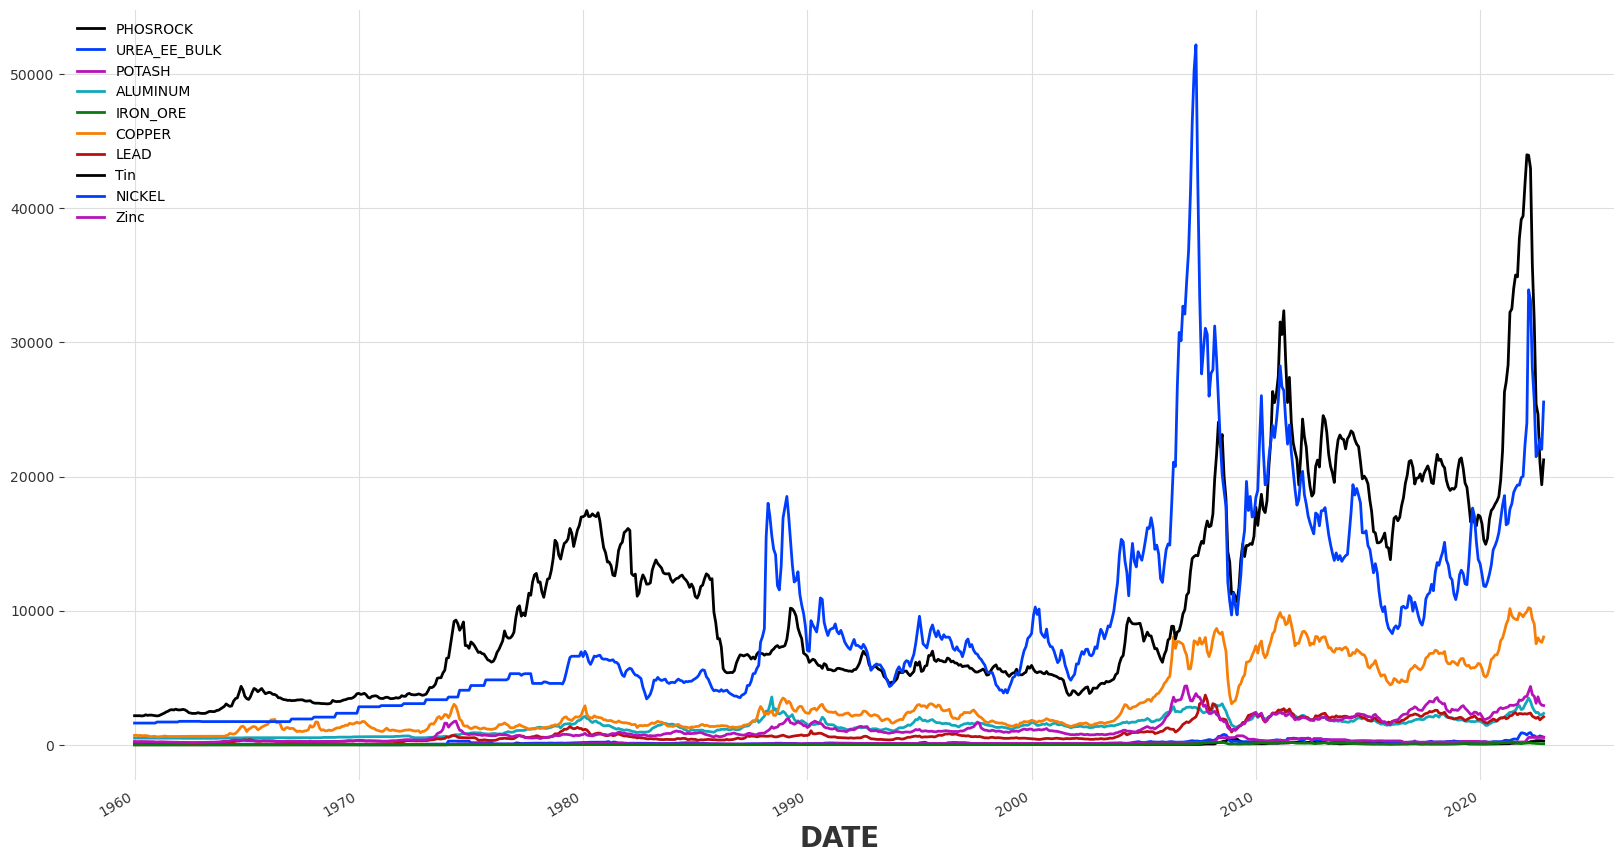

In [33]:
data.plot()

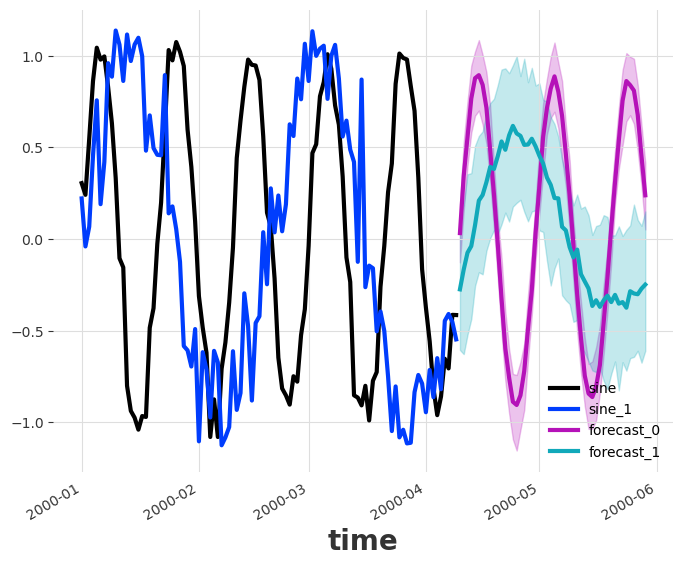

In [34]:
import darts.utils.timeseries_generation as tg
from darts.models import KalmanForecaster
series1 = tg.sine_timeseries(value_frequency=0.05, length=100) + 0.1 * tg.gaussian_timeseries(length=100)
series2 = tg.sine_timeseries(value_frequency=0.02, length=100) + 0.2 * tg.gaussian_timeseries(length=100)

multivariate_series = series1.stack(series2)

model = KalmanForecaster(dim_x=4)
model.fit(multivariate_series)
pred = model.predict(n=50, num_samples=100)

plt.figure(figsize=(8,6))
multivariate_series.plot(lw=3)
pred.plot(lw=3, label='forecast')

In [108]:
# Create training and validation sets:
train, val = data.split_after(pd.Timestamp(year=2015, month=12, day=1))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
transformer.fit(train)
train = transformer.transform(train)
val = transformer.transform(val)

In [38]:

from darts.models import NBEATSModel, RNNModel, TCNModel, NHiTSModel 

In [39]:
# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MeanAbsolutePercentageError()

# Early stop callback
my_stopper = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",  # "val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper]}

# Create the model
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=500,
    torch_metrics=torch_metrics,
    pl_trainer_kwargs=pl_trainer_kwargs)

model.fit(
    series=train,
    val_series=val,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.5 M 
---------------------------------------------------
8.5 M     Trainable params
3.2 K     Non-trainable params
8.5 M     Total params
67.892    Total estimated model params size (MB)


Epoch 0:  91%|▉| 20/22 [00:05<00:00,  3.41it/s, loss=0.342
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 0:  95%|▉| 21/22 [00:06<00:00,  3.46it/s, loss=0.342
Epoch 0: 100%|█| 22/22 [00:06<00:00,  3.57it/s, loss=0.342
Epoch 1:  91%|▉| 20/22 [00:05<00:00,  3.51it/s, loss=0.032
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 1:  95%|▉| 21/22 [00:05<00:00,  3.57it/s, loss=0.032
Epoch 1: 100%|█| 22/22 [00:06<00:00,  3.57it/s, loss=0.032
Epoch 2:  91%|▉| 20/22 [00:05<00:00,  3.76it/s, loss=0.016
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 2:  95%|▉| 21/22 [00:05<00:00,  3.81it/s, loss=0.016
Epoch 2: 100%|█| 22/22 [00:05<00:00,  3.93it/s, loss=0.016
Epoch 3:  91%|▉| 20/22 [00:04<00:00,  4.33it/s, loss=0.010
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 3:  95%|▉| 21/22 [00:04<00:00,  4.40it/s, lo

In [104]:
pred_air = model.predict(series=train, n=24)

Predicting DataLoader 0: 100%|█| 1/1 [00:00<00:00, 11.00it


In [78]:
pred_air = transformer.inverse_transform(pred_air)

In [44]:
pred_air.columns

Index(['PHOSROCK', 'UREA_EE_BULK', 'POTASH', 'ALUMINUM', 'IRON_ORE', 'COPPER',
       'LEAD', 'Tin', 'NICKEL', 'Zinc', 'GOLD', 'PLATINUM', 'SILVER'],
      dtype='object', name='component')

In [55]:

# A TorchMetric or val_loss can be used as the monitor
torch_metrics_rnn = MeanAbsolutePercentageError()

# Early stop callback
my_stopper_rnn = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",  # "val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs_rnn = {"callbacks": [my_stopper_rnn]}

# Create the model
model_rnn = RNNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=500,
    torch_metrics=torch_metrics_rnn,
    pl_trainer_kwargs=pl_trainer_kwargs_rnn)

model_rnn.fit(
    series=train,
    val_series=val,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.0 K 
4 | V             | Linear           | 338   
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.011     Total estimated model params size (MB)


Epoch 0:  91%|▉| 21/23 [00:00<00:00, 30.48it/s, loss=0.045
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 0:  96%|▉| 22/23 [00:00<00:00, 29.52it/s, loss=0.045
Epoch 0: 100%|█| 23/23 [00:00<00:00, 29.68it/s, loss=0.045
Epoch 1:  91%|▉| 21/23 [00:00<00:00, 22.24it/s, loss=0.019
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 1:  96%|▉| 22/23 [00:01<00:00, 20.80it/s, loss=0.019
Epoch 1: 100%|█| 23/23 [00:01<00:00, 20.39it/s, loss=0.019
Epoch 2:  91%|▉| 21/23 [00:01<00:00, 15.13it/s, loss=0.010
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 2:  96%|▉| 22/23 [00:01<00:00, 14.57it/s, loss=0.010
Epoch 2: 100%|█| 23/23 [00:01<00:00, 14.81it/s, loss=0.010
Epoch 3:  91%|▉| 21/23 [00:01<00:00, 20.10it/s, loss=0.008
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 3:  96%|▉| 22/23 [00:01<00:00, 20.27it/s, lo

In [106]:
pred_air_rnn = model_rnn.predict(series=train, n=24)

Predicting DataLoader 0: 100%|█| 1/1 [00:00<00:00, 26.91it


In [80]:
pred_air_rnn = transformer.inverse_transform(pred_air_rnn)

In [61]:
# A TorchMetric or val_loss can be used as the monitor
torch_metrics_tcn = MeanAbsolutePercentageError()

# Early stop callback
my_stopper_tcn = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",  # "val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs_tcn = {"callbacks": [my_stopper_tcn]}

# Create the model
model_tcn = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=500,
    torch_metrics=torch_metrics_tcn,
    pl_trainer_kwargs=pl_trainer_kwargs_tcn)

model_tcn.fit(
    series=train,
    val_series=val,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 464   
----------------------------------------------------
464       Trainable params
0         Non-trainable params
464       Total params
0.004     Total estimated model params size (MB)


Epoch 0:  91%|▉| 20/22 [00:00<00:00, 28.74it/s, loss=0.278
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 0:  95%|▉| 21/22 [00:00<00:00, 25.32it/s, loss=0.278
Epoch 0: 100%|█| 22/22 [00:00<00:00, 24.59it/s, loss=0.278
Epoch 1:  91%|▉| 20/22 [00:01<00:00, 13.91it/s, loss=0.2, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 1:  95%|▉| 21/22 [00:01<00:00, 10.85it/s, loss=0.2, 
Epoch 1: 100%|█| 22/22 [00:02<00:00, 10.92it/s, loss=0.2, 
Epoch 2:  91%|▉| 20/22 [00:00<00:00, 28.50it/s, loss=0.148
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 2:  95%|▉| 21/22 [00:00<00:00, 28.03it/s, loss=0.148
Epoch 2: 100%|█| 22/22 [00:00<00:00, 28.36it/s, loss=0.148
Epoch 3:  91%|▉| 20/22 [00:00<00:00, 26.50it/s, loss=0.113
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 3:  95%|▉| 21/22 [00:00<00:00, 23.56it/s, lo

In [109]:
pred_air_tcn = model_tcn.predict(series=train, n=24)

Predicting DataLoader 0: 100%|█| 1/1 [00:00<00:00, 53.29it


In [82]:
pred_air_tcn = transformer.inverse_transform(pred_air_tcn)

In [65]:
# A TorchMetric or val_loss can be used as the monitor
torch_metrics_nhit = MeanAbsolutePercentageError()

# Early stop callback
my_stopper_nhit = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",  # "val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs_nhit = {"callbacks": [my_stopper_nhit]}

# Create the model
model_nhit = NHiTSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=500,
    torch_metrics=torch_metrics_nhit,
    pl_trainer_kwargs=pl_trainer_kwargs_nhit)

model_nhit.fit(
    series=train,
    val_series=val,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.4 M 
---------------------------------------------------
1.3 M     Trainable params
160 K     Non-trainable params
1.4 M     Total params
11.328    Total estimated model params size (MB)


Epoch 0:  91%|▉| 20/22 [00:02<00:00,  9.23it/s, loss=0.020
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 0:  95%|▉| 21/22 [00:02<00:00,  9.33it/s, loss=0.020
Epoch 0: 100%|█| 22/22 [00:02<00:00,  9.58it/s, loss=0.020
Epoch 1:  91%|▉| 20/22 [00:01<00:00, 13.09it/s, loss=0.007
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 1:  95%|▉| 21/22 [00:01<00:00, 12.05it/s, loss=0.007
Epoch 1: 100%|█| 22/22 [00:01<00:00, 11.99it/s, loss=0.007
Epoch 2:  91%|▉| 20/22 [00:02<00:00,  9.42it/s, loss=0.004
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 2:  95%|▉| 21/22 [00:02<00:00,  9.44it/s, loss=0.004
Epoch 2: 100%|█| 22/22 [00:02<00:00,  9.69it/s, loss=0.004
Epoch 3:  91%|▉| 20/22 [00:02<00:00,  8.87it/s, loss=0.003
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/2 [00:00<?, ?it/s]
Epoch 3:  95%|▉| 21/22 [00:02<00:00,  9.04it/s, lo

In [110]:
pred_air_nhit = model_nhit.predict(series=train, n=24)

Predicting DataLoader 0: 100%|█| 1/1 [00:00<00:00,  8.24it


In [84]:
pred_air_nhit = transformer.inverse_transform(pred_air_nhit)

In [87]:
val = transformer.inverse_transform(val)

In [112]:
def eval_deep(forecast, horizon=24, Name=None, column=None ):
    if column != None:
        print("Model {} obtains MAPE: {:.2f}% MAE: {:.2f} RMSE: {:.2f}".format(Name, mape(val[:horizon][column], forecast[column]),mae(val[:horizon][column], forecast[column]),rmse(val[:horizon][column], forecast[column])))        
    else:
        print("Model {} obtains MAPE: {:.2f}% MAE: {:.2f} RMSE: {:.2f}".format(Name, mape(val[:horizon], forecast),mae(val[:horizon], forecast),rmse(val[:horizon], forecast)))        


In [113]:
for name in data.columns:
    print(" Forecasting for:",name)
    eval_deep(pred_air, Name='NBEATS', column=name)
    eval_deep(pred_air_rnn, Name='RNN', column=name)
    eval_deep(pred_air_tcn, Name='TCN', column=name)
    eval_deep(pred_air_nhit, Name='NHITS', column=name)
    print(" -------------------------------------------")


 Forecasting for: PHOSROCK
Model NBEATS obtains MAPE: 28.70% MAE: 0.06 RMSE: 0.06
Model RNN obtains MAPE: 30.55% MAE: 0.06 RMSE: 0.07
Model TCN obtains MAPE: 13.66% MAE: 0.03 RMSE: 0.04
Model NHITS obtains MAPE: 22.05% MAE: 0.05 RMSE: 0.05
 -------------------------------------------
 Forecasting for: UREA_EE_BULK
Model NBEATS obtains MAPE: 45.22% MAE: 0.10 RMSE: 0.12
Model RNN obtains MAPE: 63.88% MAE: 0.15 RMSE: 0.16
Model TCN obtains MAPE: 29.01% MAE: 0.07 RMSE: 0.07
Model NHITS obtains MAPE: 18.96% MAE: 0.04 RMSE: 0.05
 -------------------------------------------
 Forecasting for: POTASH
Model NBEATS obtains MAPE: 26.44% MAE: 0.08 RMSE: 0.09
Model RNN obtains MAPE: 47.19% MAE: 0.14 RMSE: 0.16
Model TCN obtains MAPE: 20.82% MAE: 0.06 RMSE: 0.07
Model NHITS obtains MAPE: 12.05% MAE: 0.04 RMSE: 0.05
 -------------------------------------------
 Forecasting for: ALUMINUM
Model NBEATS obtains MAPE: 25.74% MAE: 0.10 RMSE: 0.11
Model RNN obtains MAPE: 39.99% MAE: 0.16 RMSE: 0.16
Model TCN

In [111]:
eval_deep(pred_air, Name='NBEATS')
eval_deep(pred_air_rnn, Name='RNN')
eval_deep(pred_air_tcn, Name='TCN')
eval_deep(pred_air_nhit, Name='NHITS')


Model NBEATS obtains MAPE: 30.06% MAE: 0.11 RMSE: 0.12
Model RNN obtains MAPE: 38.81% MAE: 0.12 RMSE: 0.13
Model TCN obtains MAPE: 25.62% MAE: 0.10 RMSE: 0.11
Model NHITS obtains MAPE: 24.02% MAE: 0.11 RMSE: 0.12


In [ ]:
eval_deep(pred_air, Name='NBEATS')
eval_deep(pred_air_rnn, Name='RNN')
eval_deep(pred_air_tcn, Name='TCN')
eval_deep(pred_air_nhit, Name='NHITS')

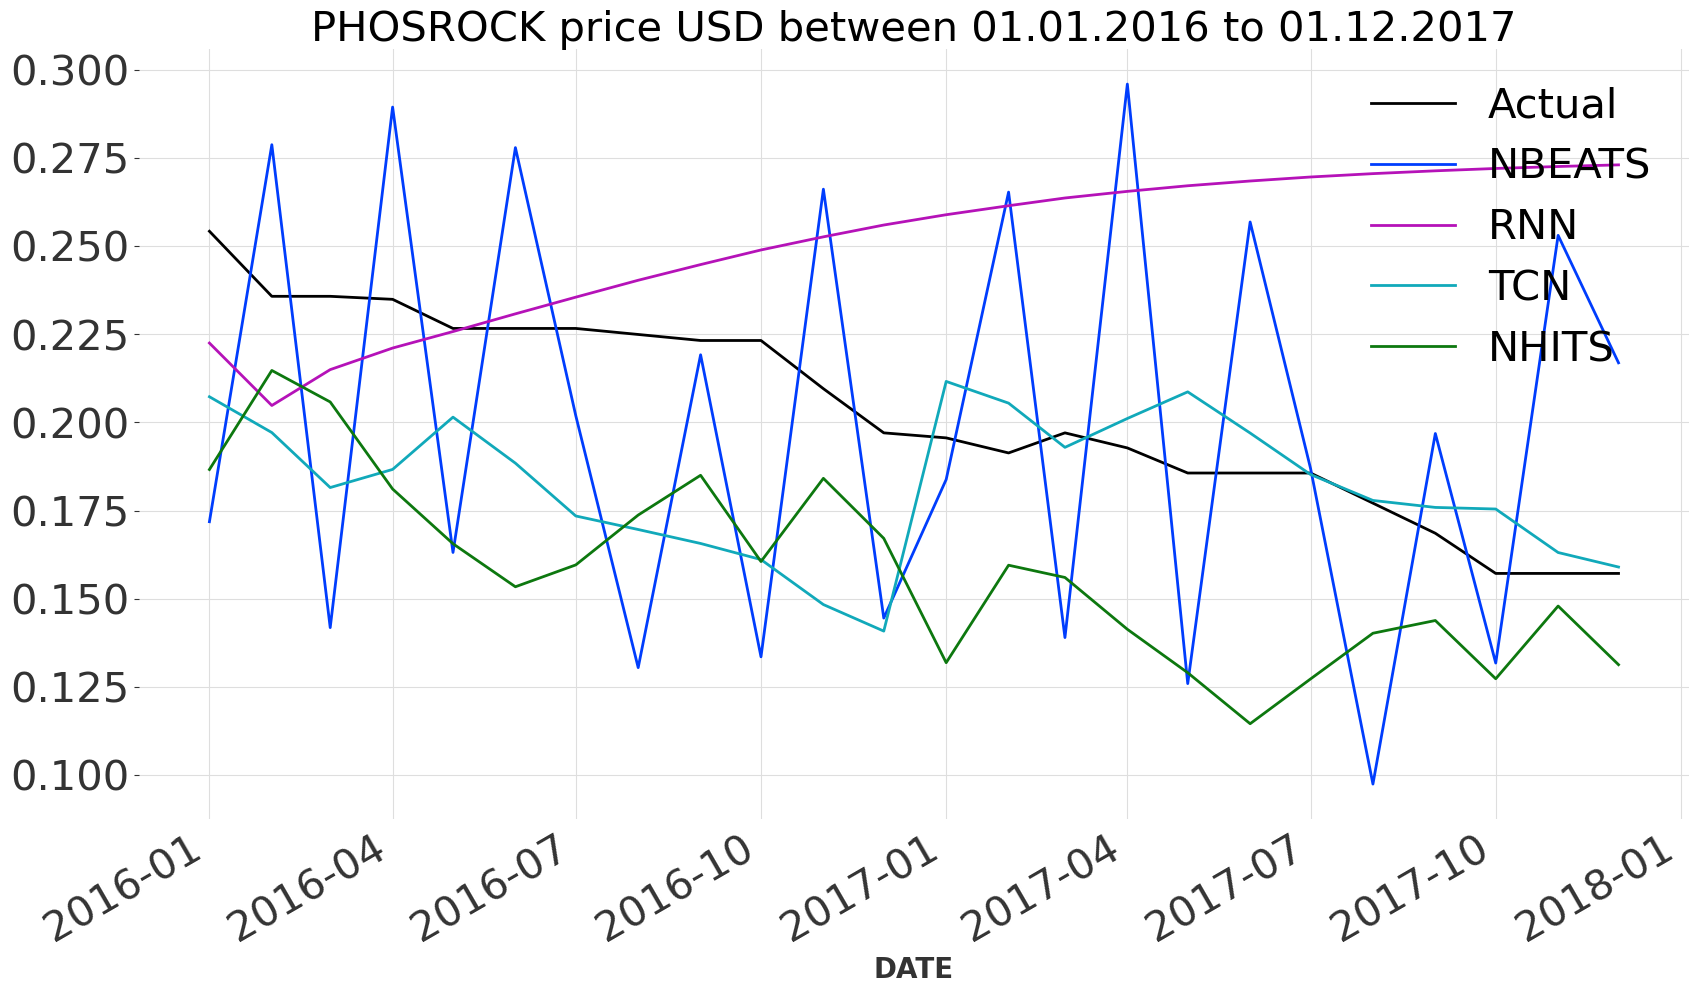

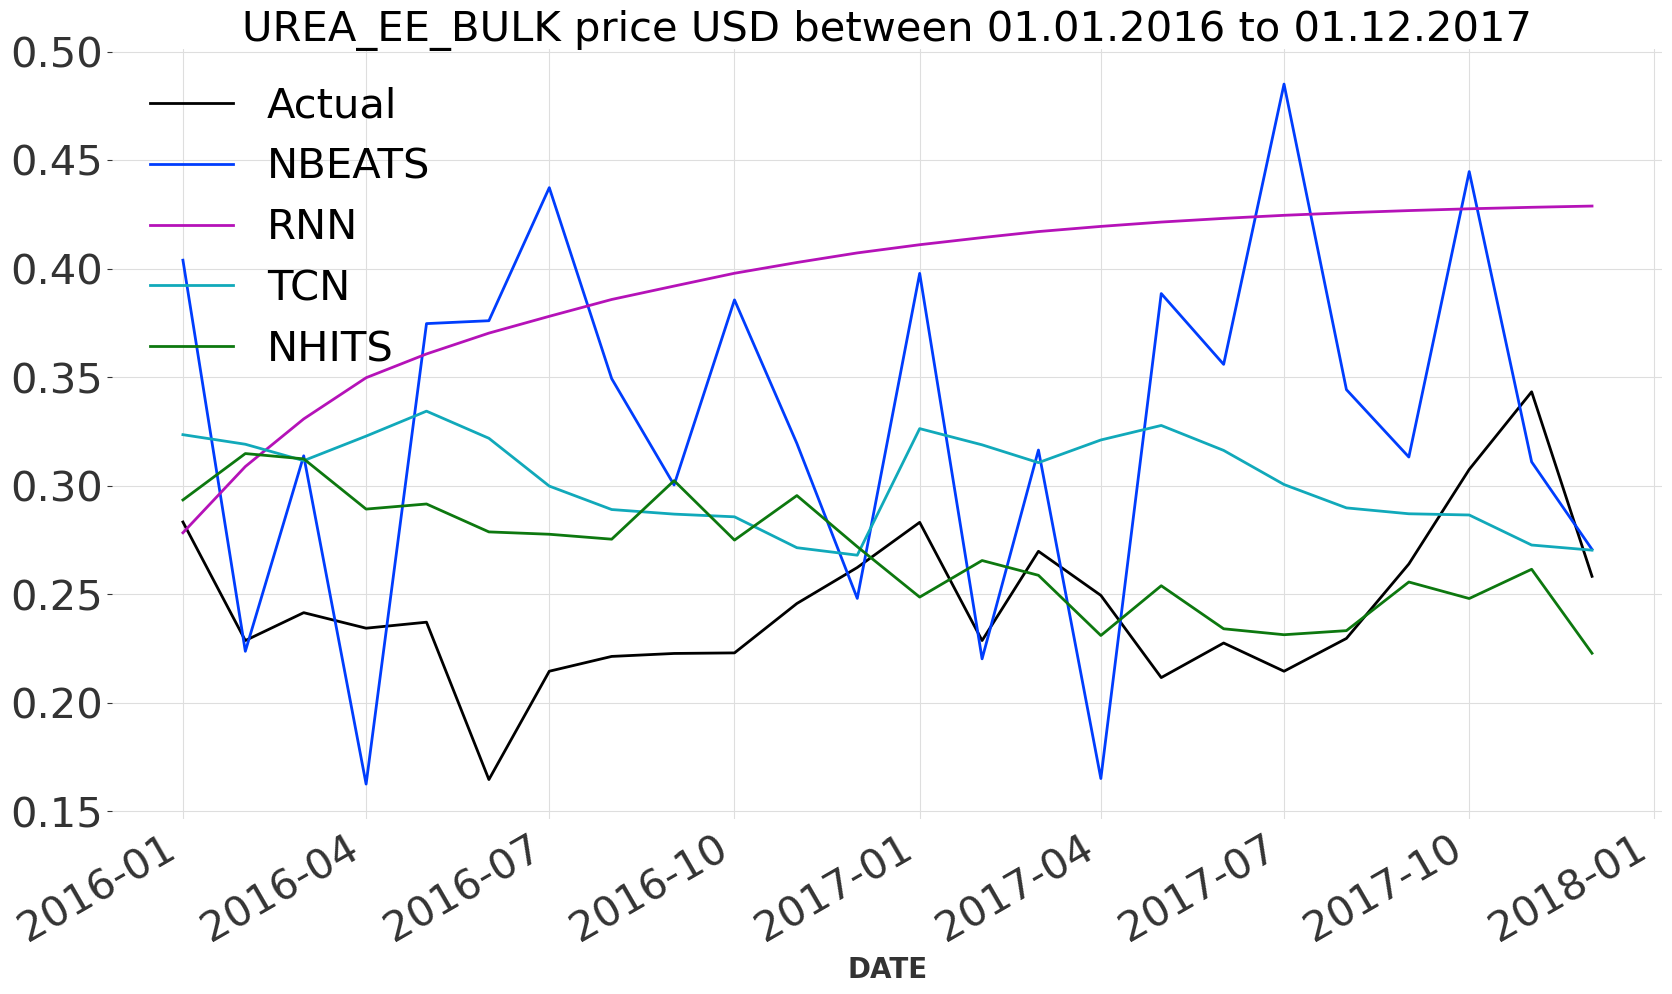

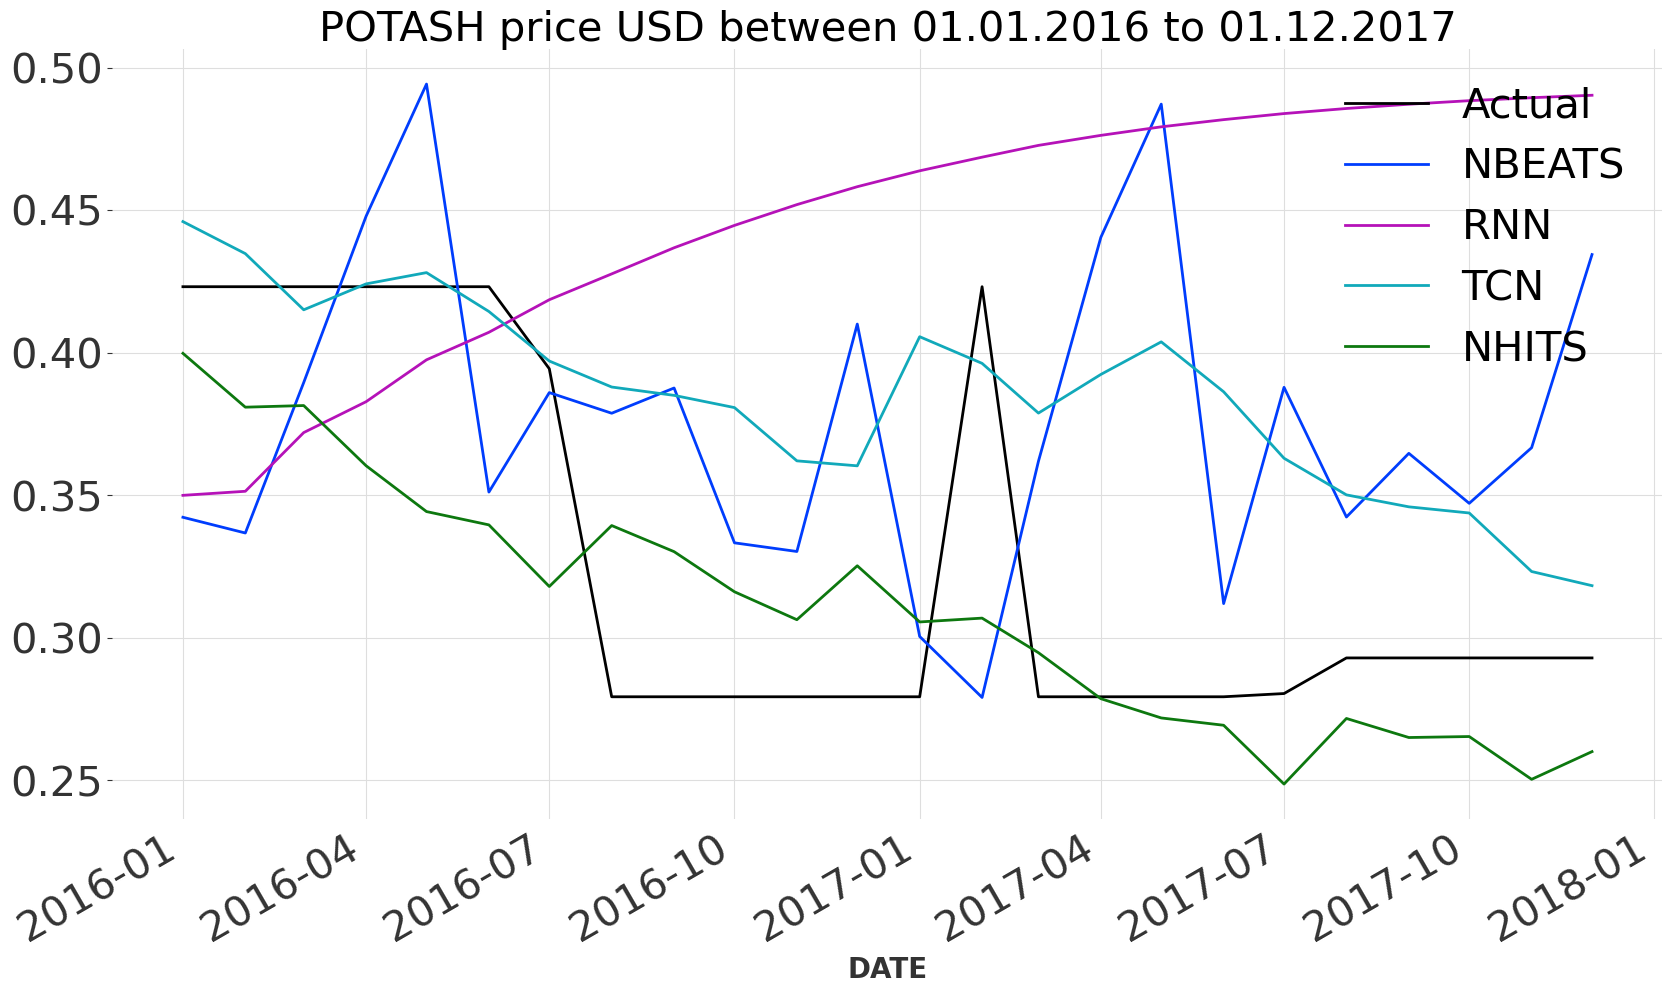

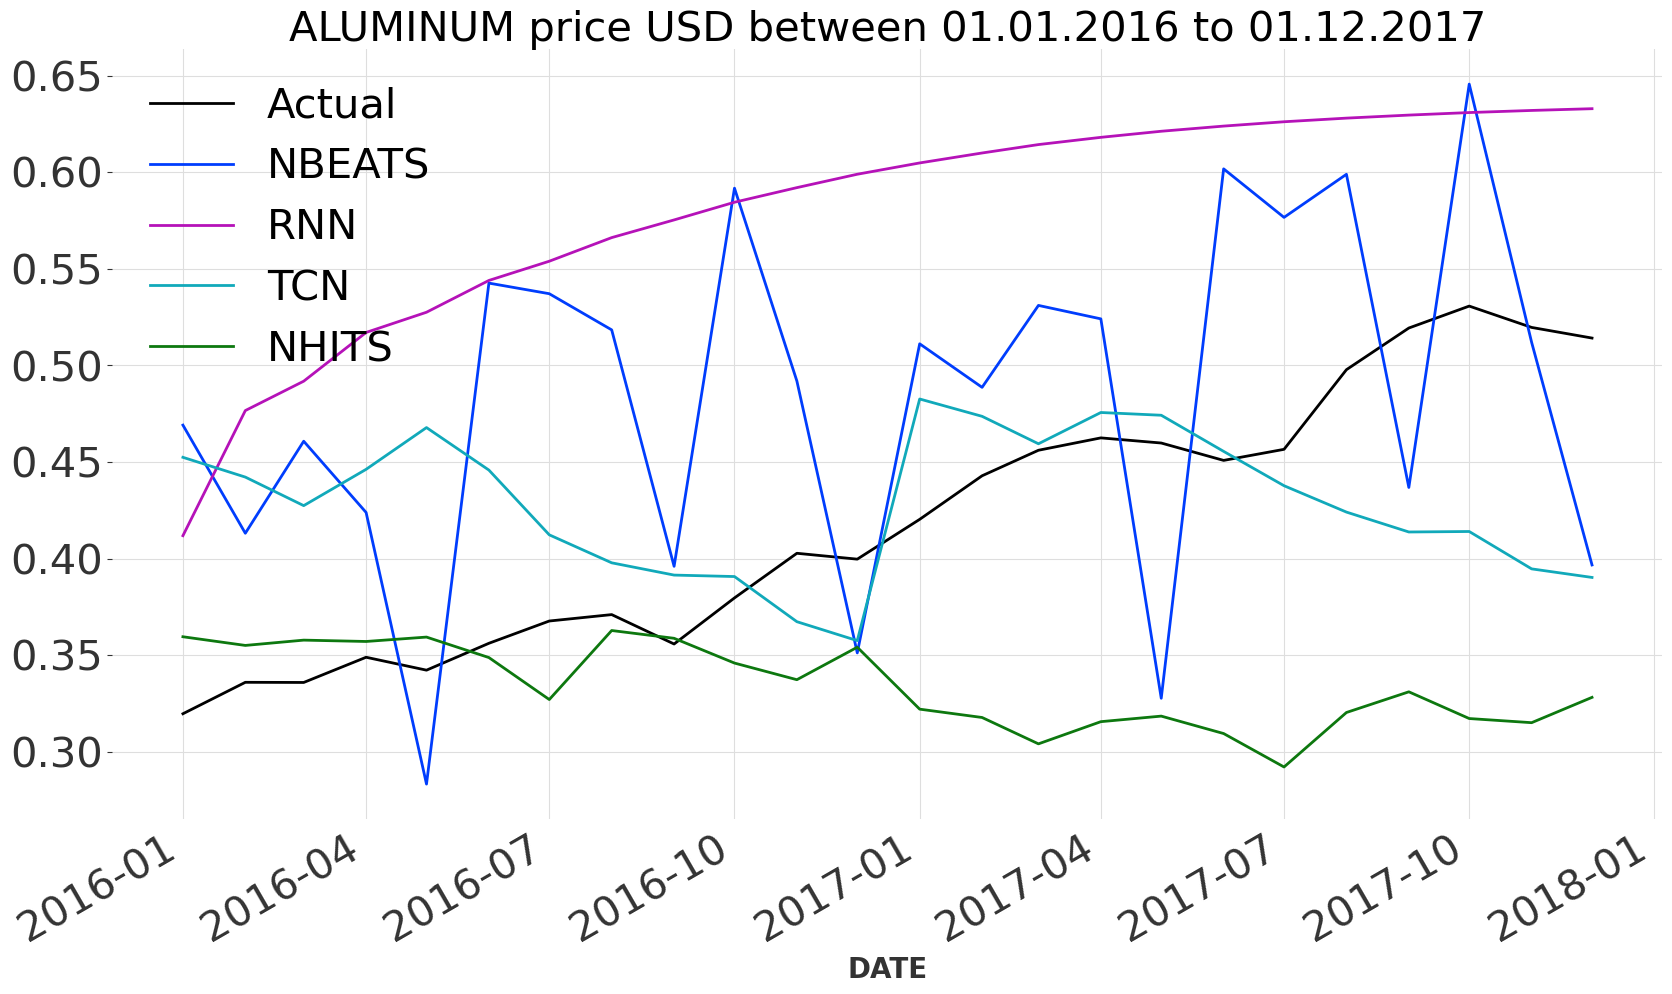

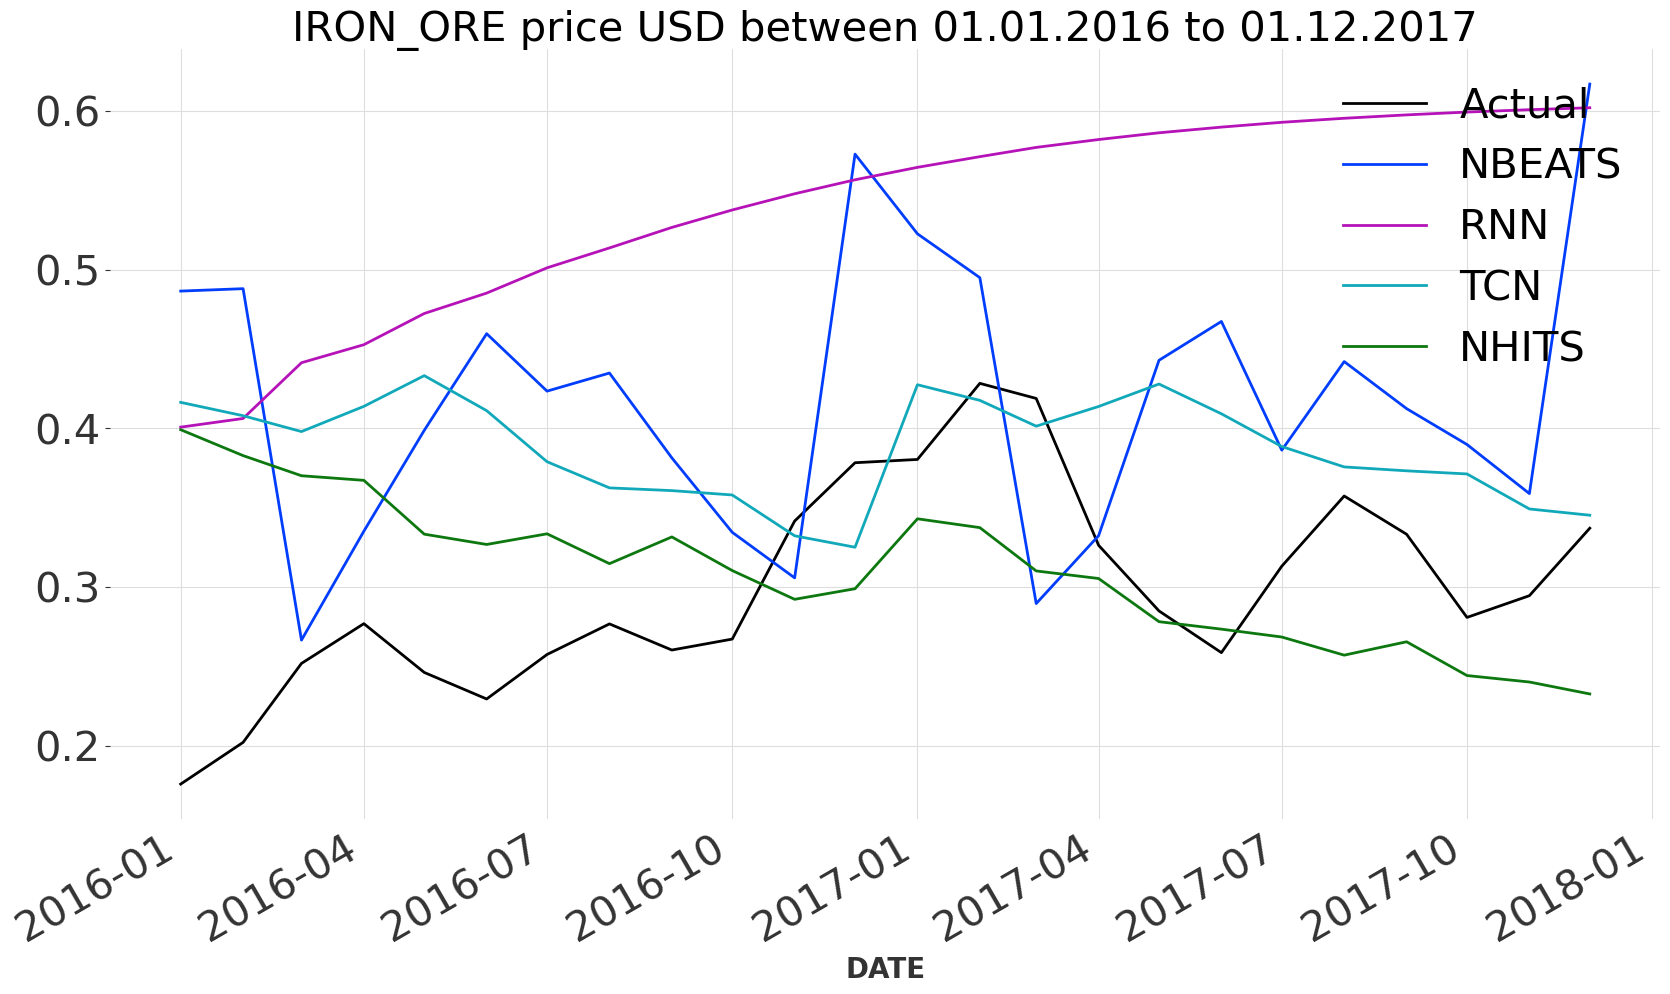

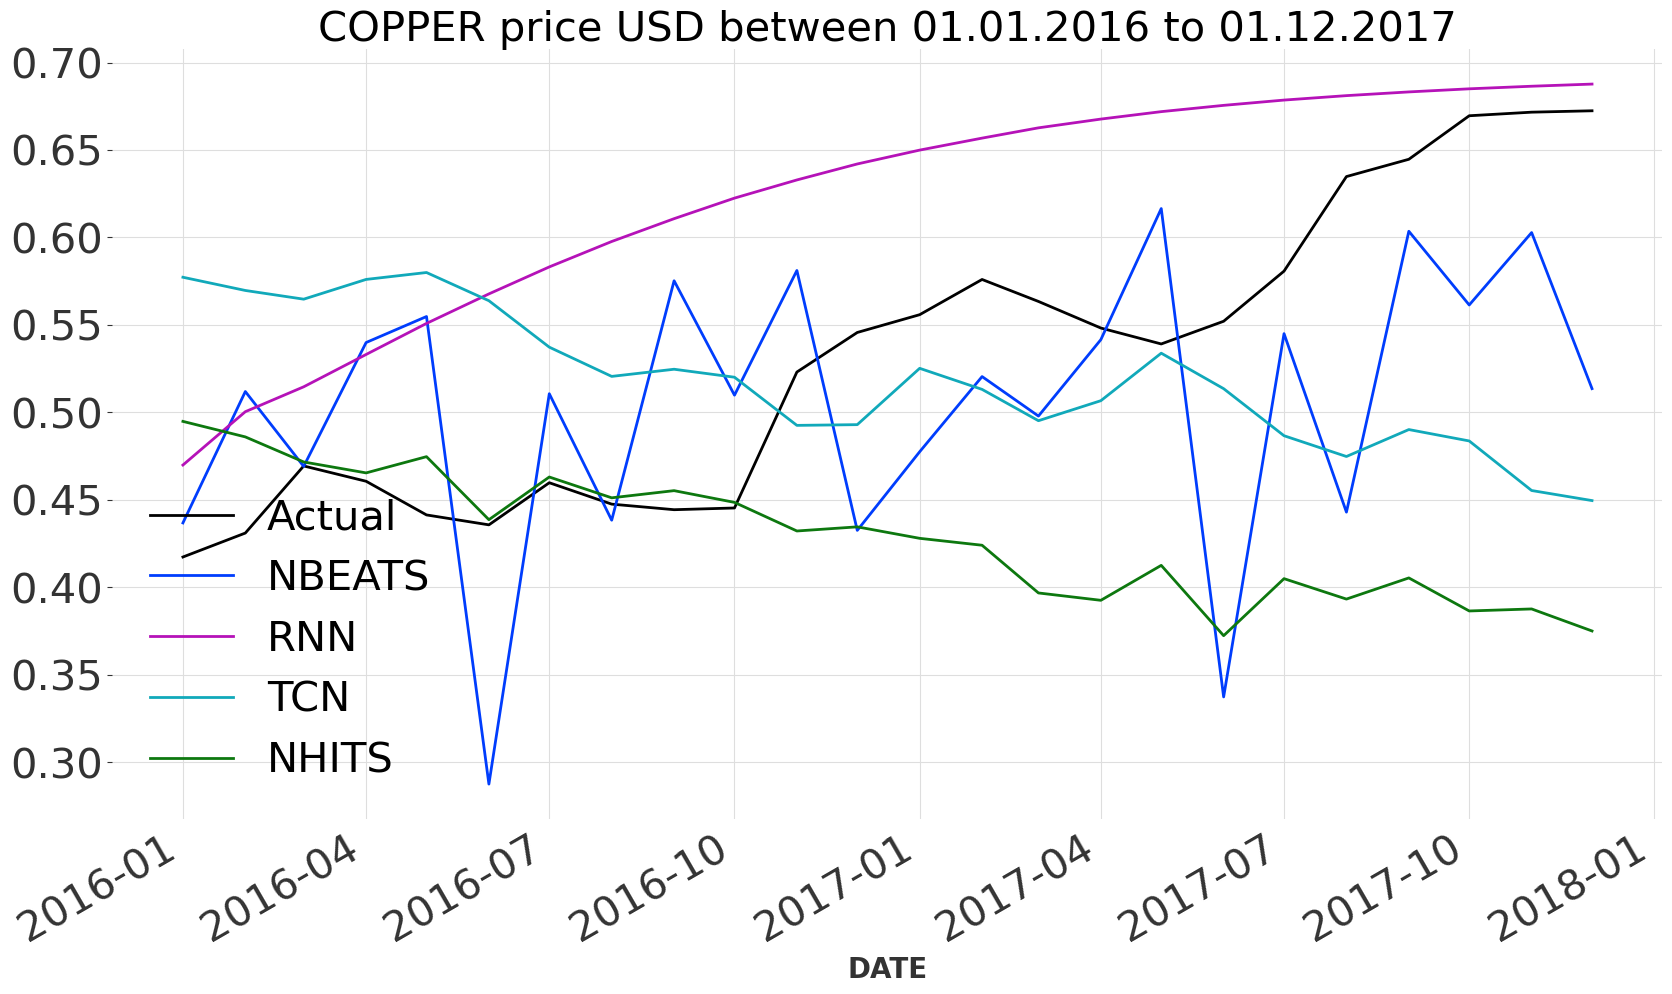

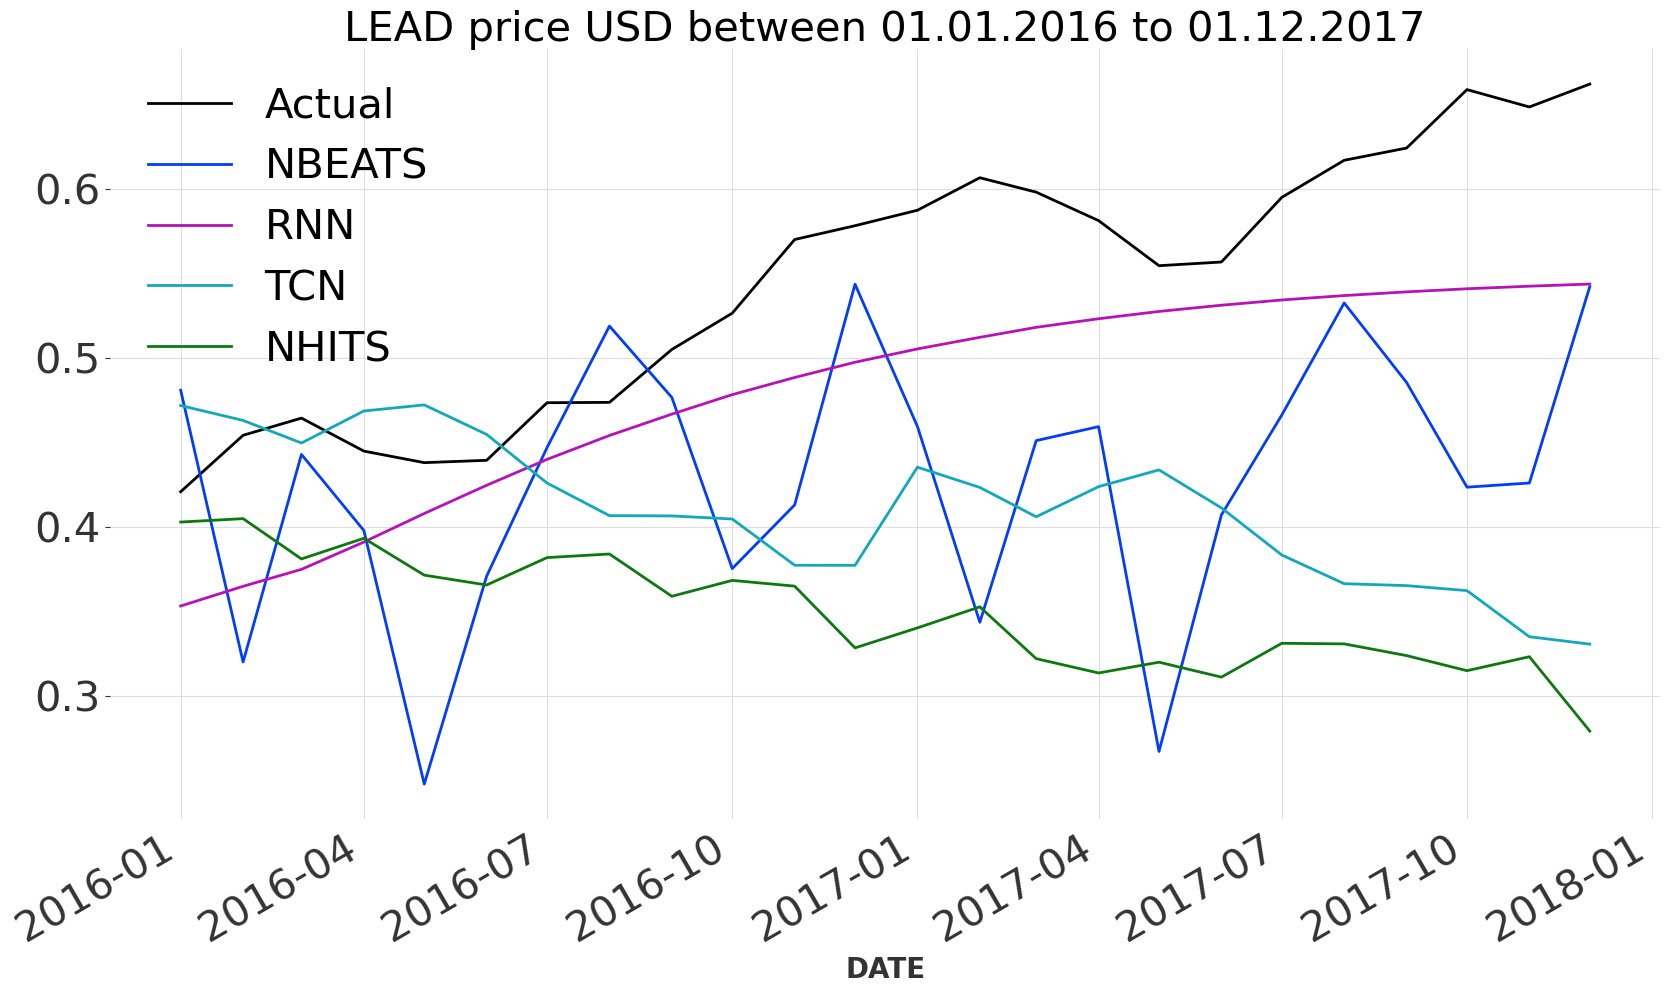

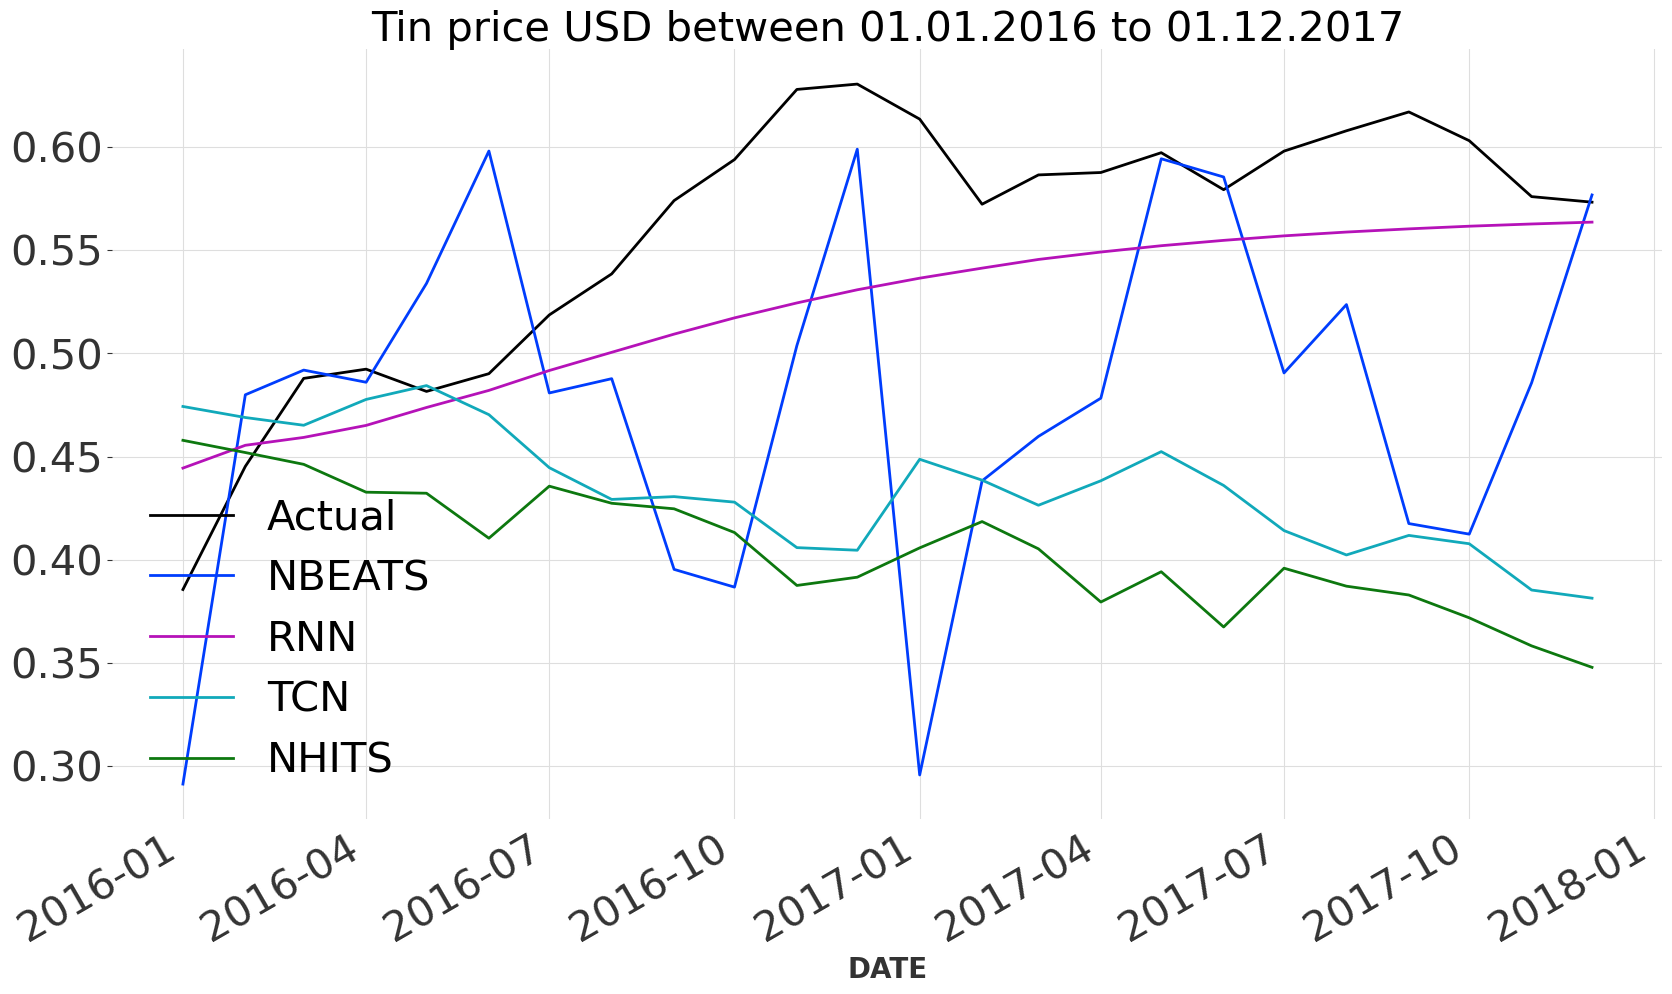

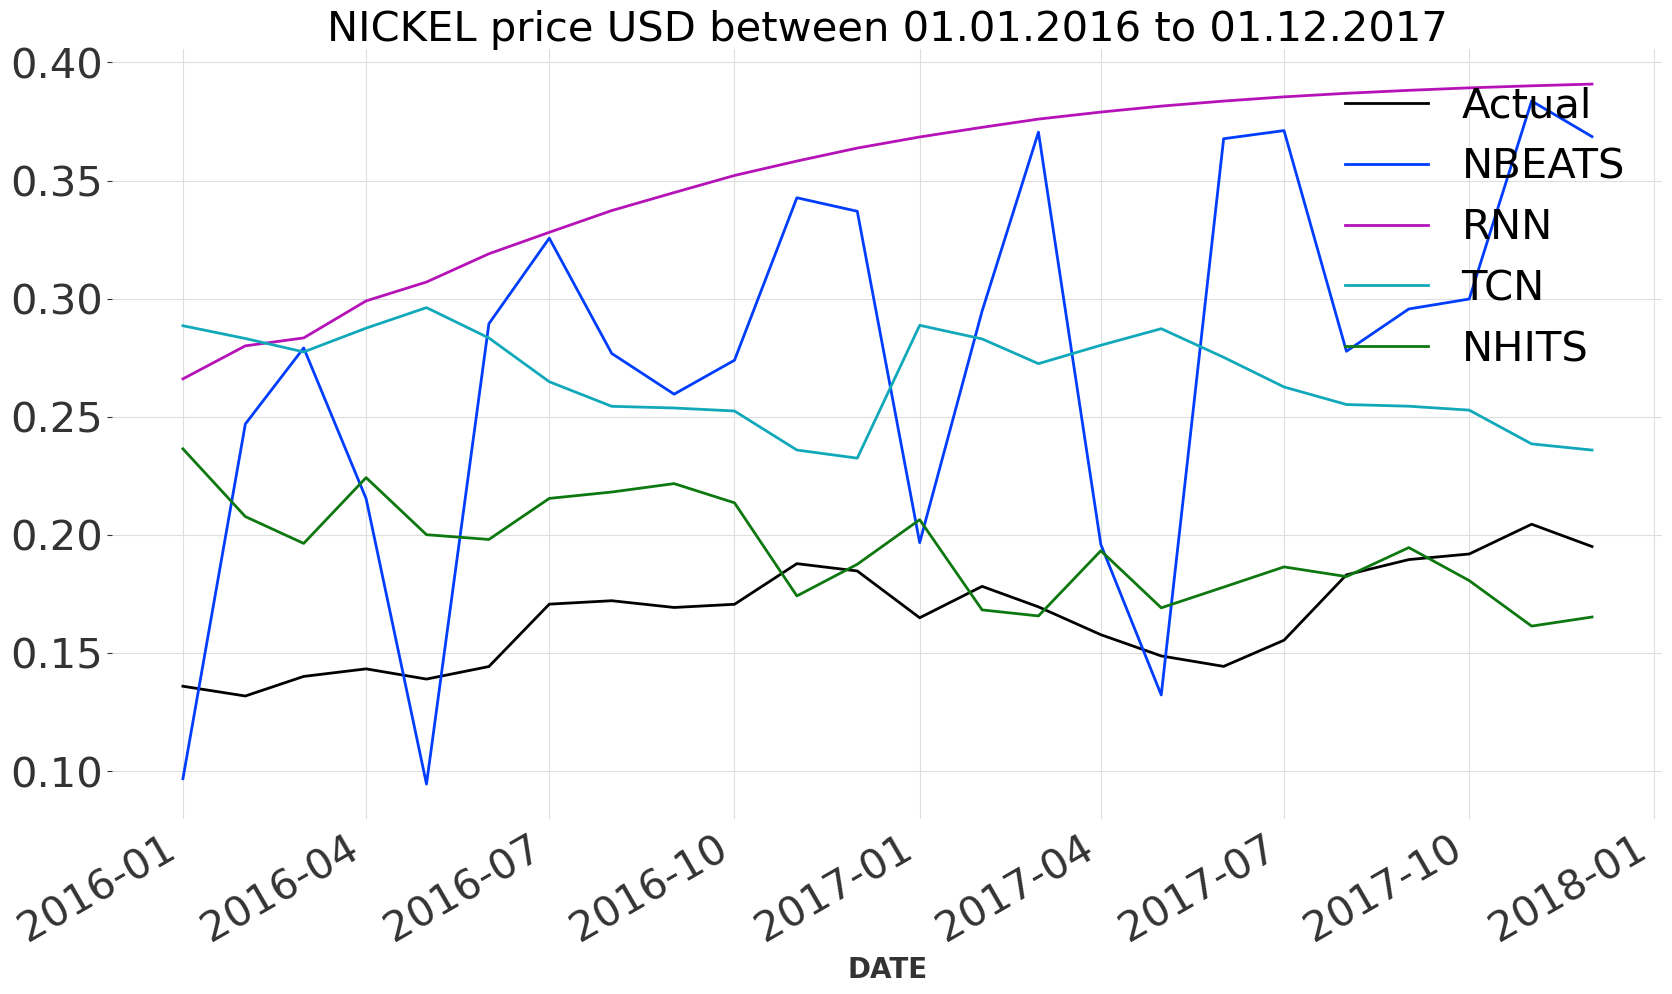

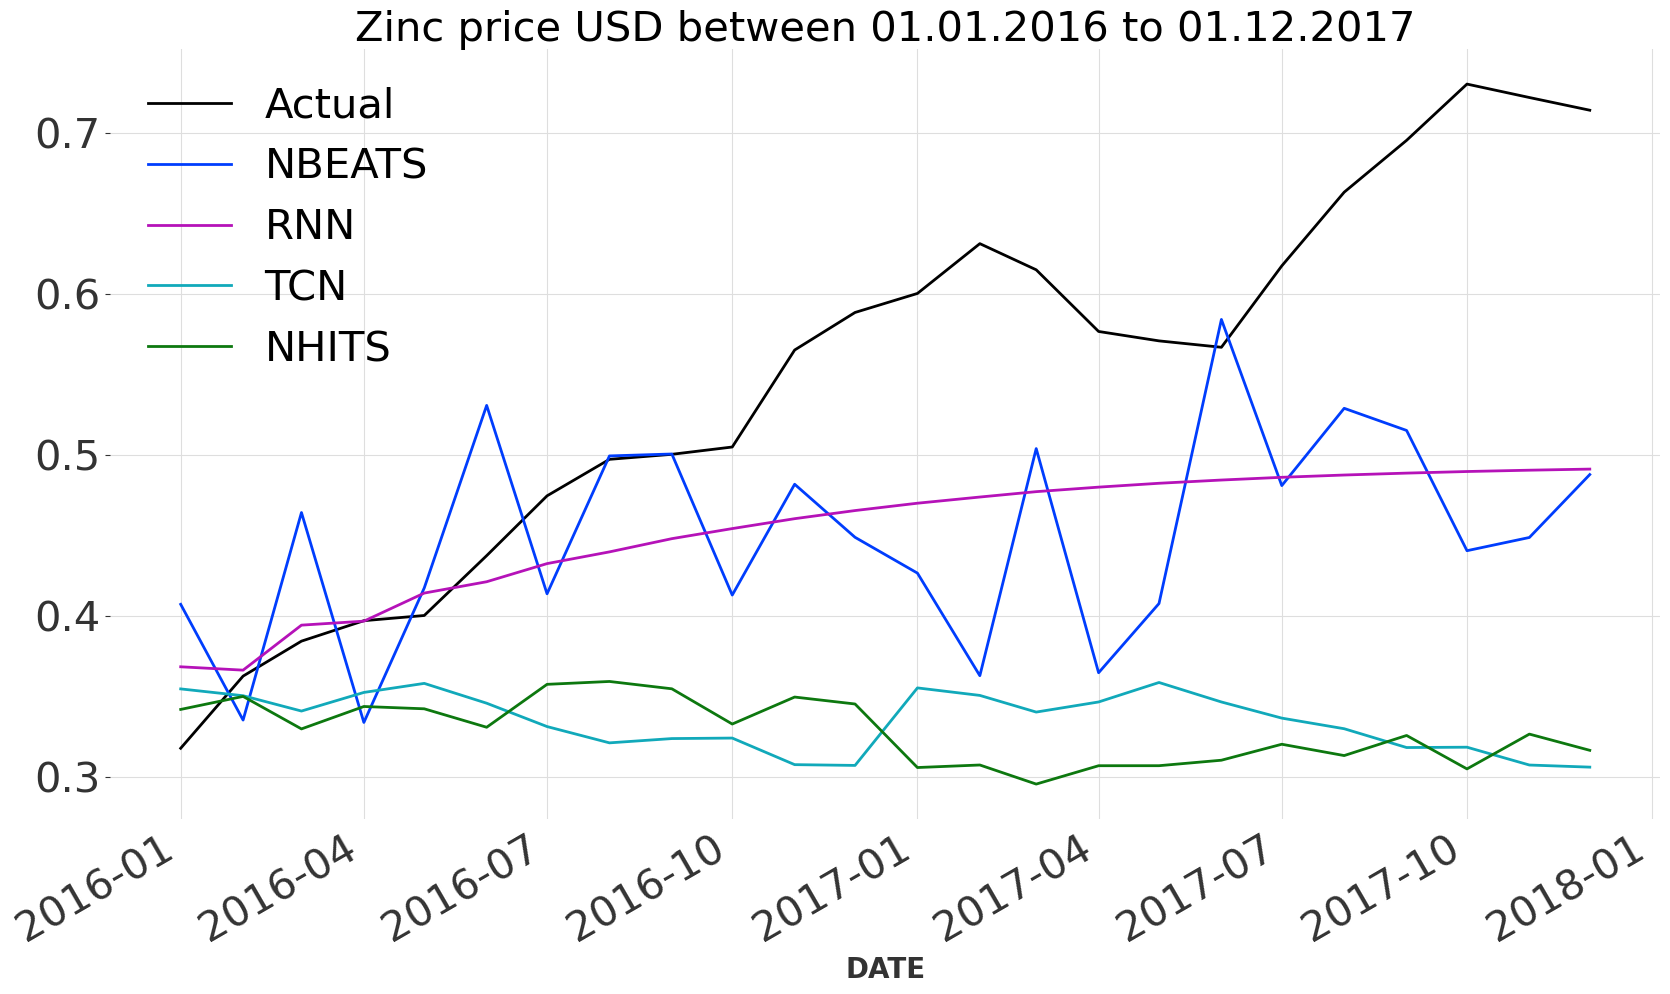

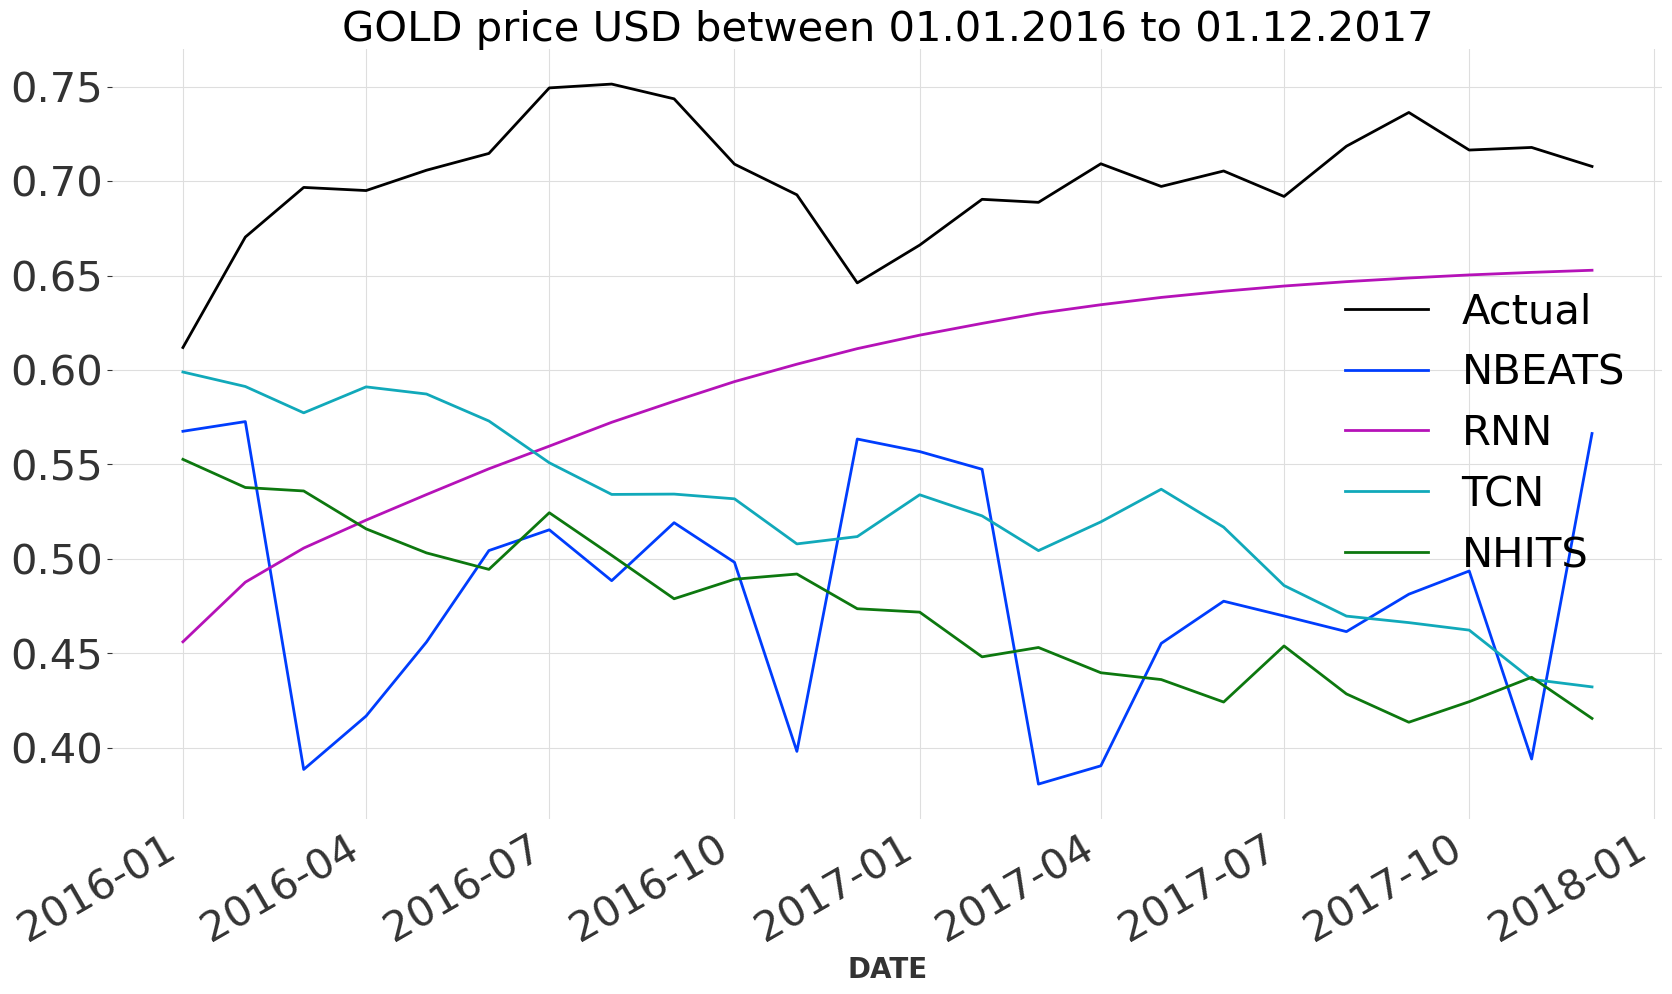

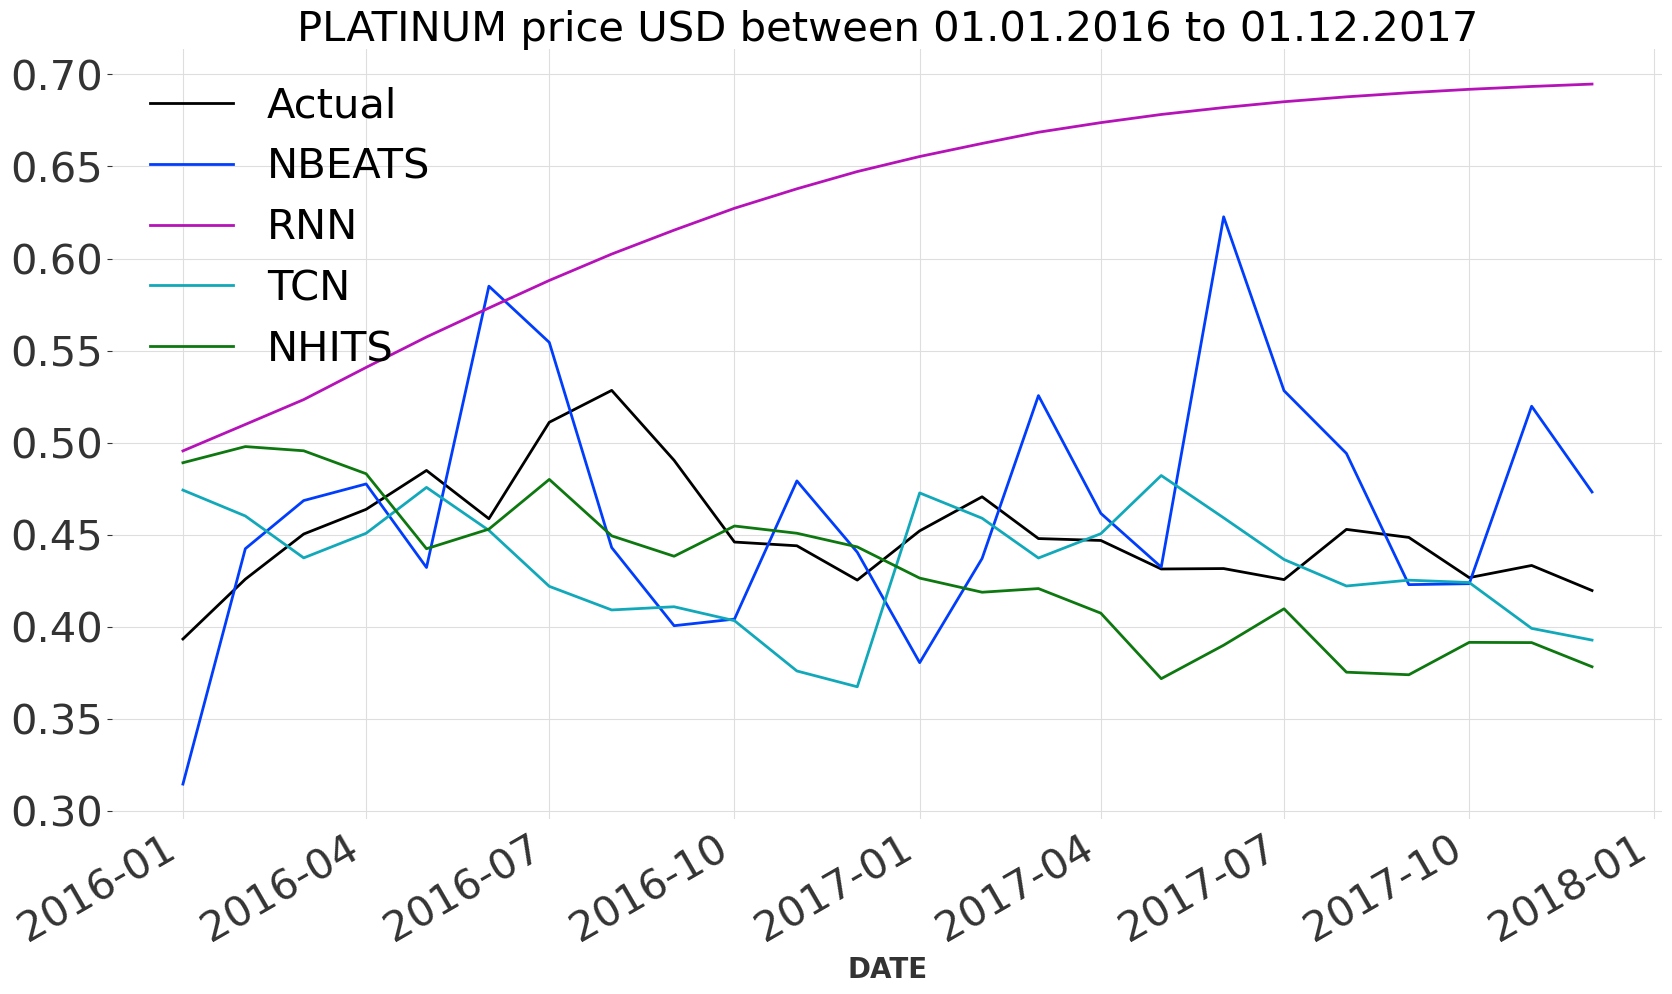

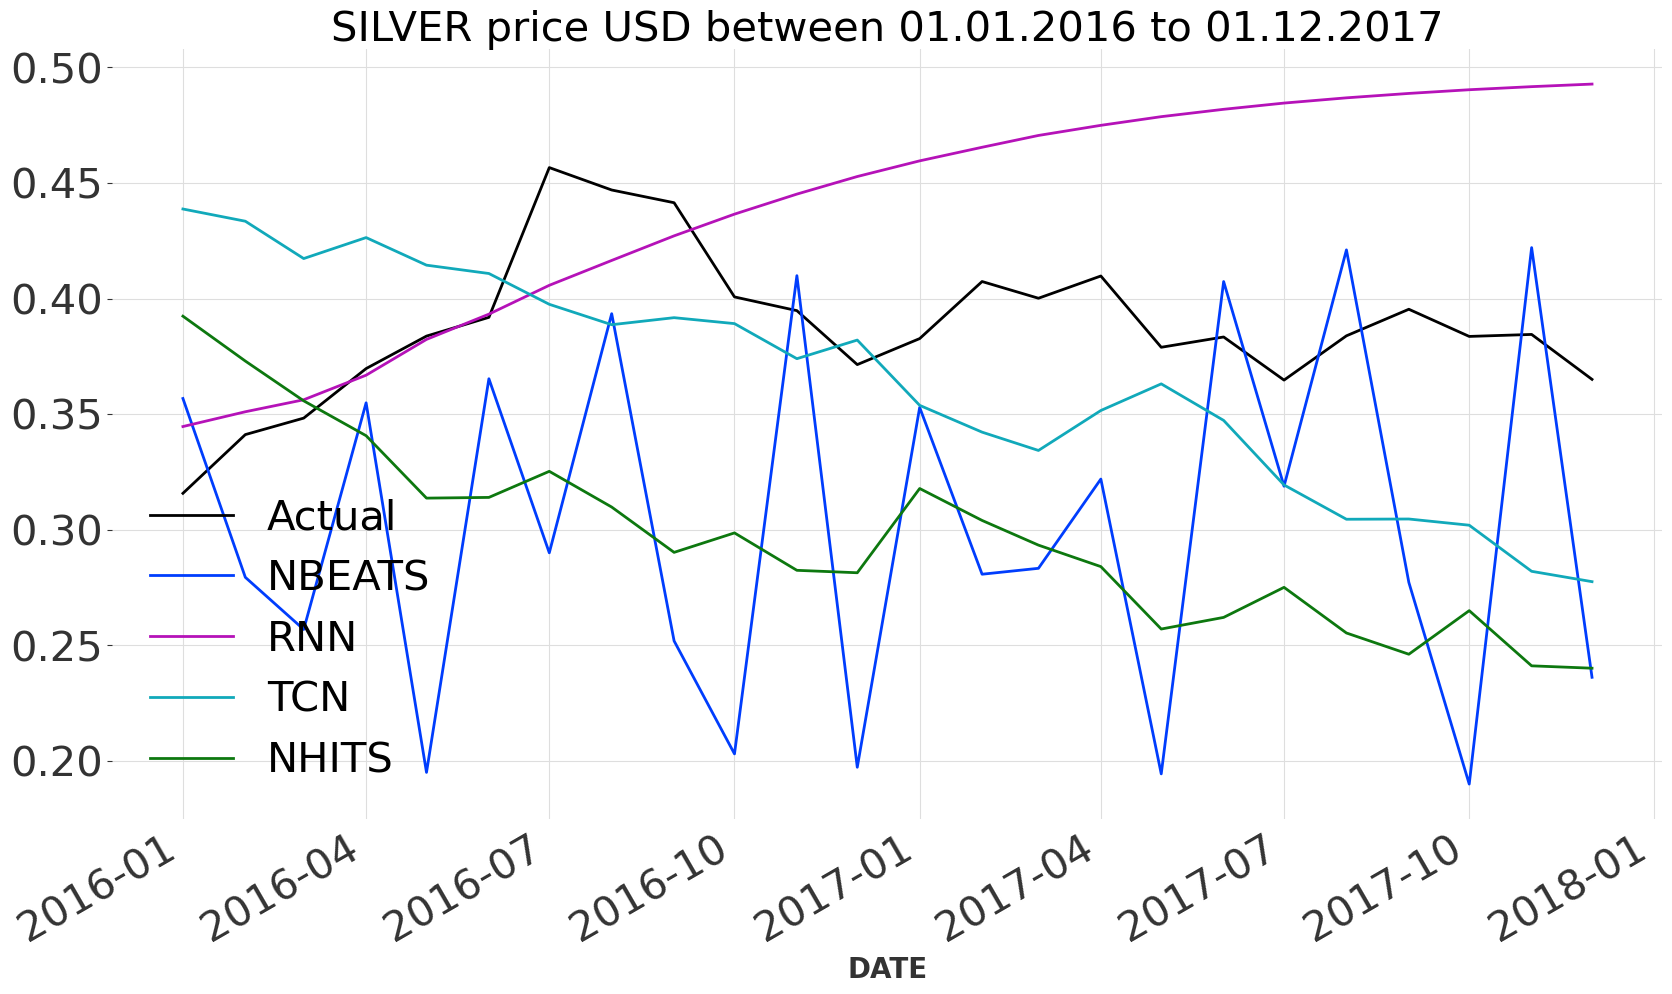

In [117]:
for name in data.columns:
    val[:24][name].plot(label='Actual')
    pred_air[name].plot(label='NBEATS')
    pred_air_rnn[name].plot(label='RNN')
    pred_air_tcn[name].plot(label='TCN')
    pred_air_nhit[name].plot(label='NHITS')
    plt.title(f"{name} price USD between 01.01.2016 to 01.12.2017")
    plt.show()

Text(0.5, 1.0, 'PHOSROCK price USD between 01.01.2016 to 01.12.2017')

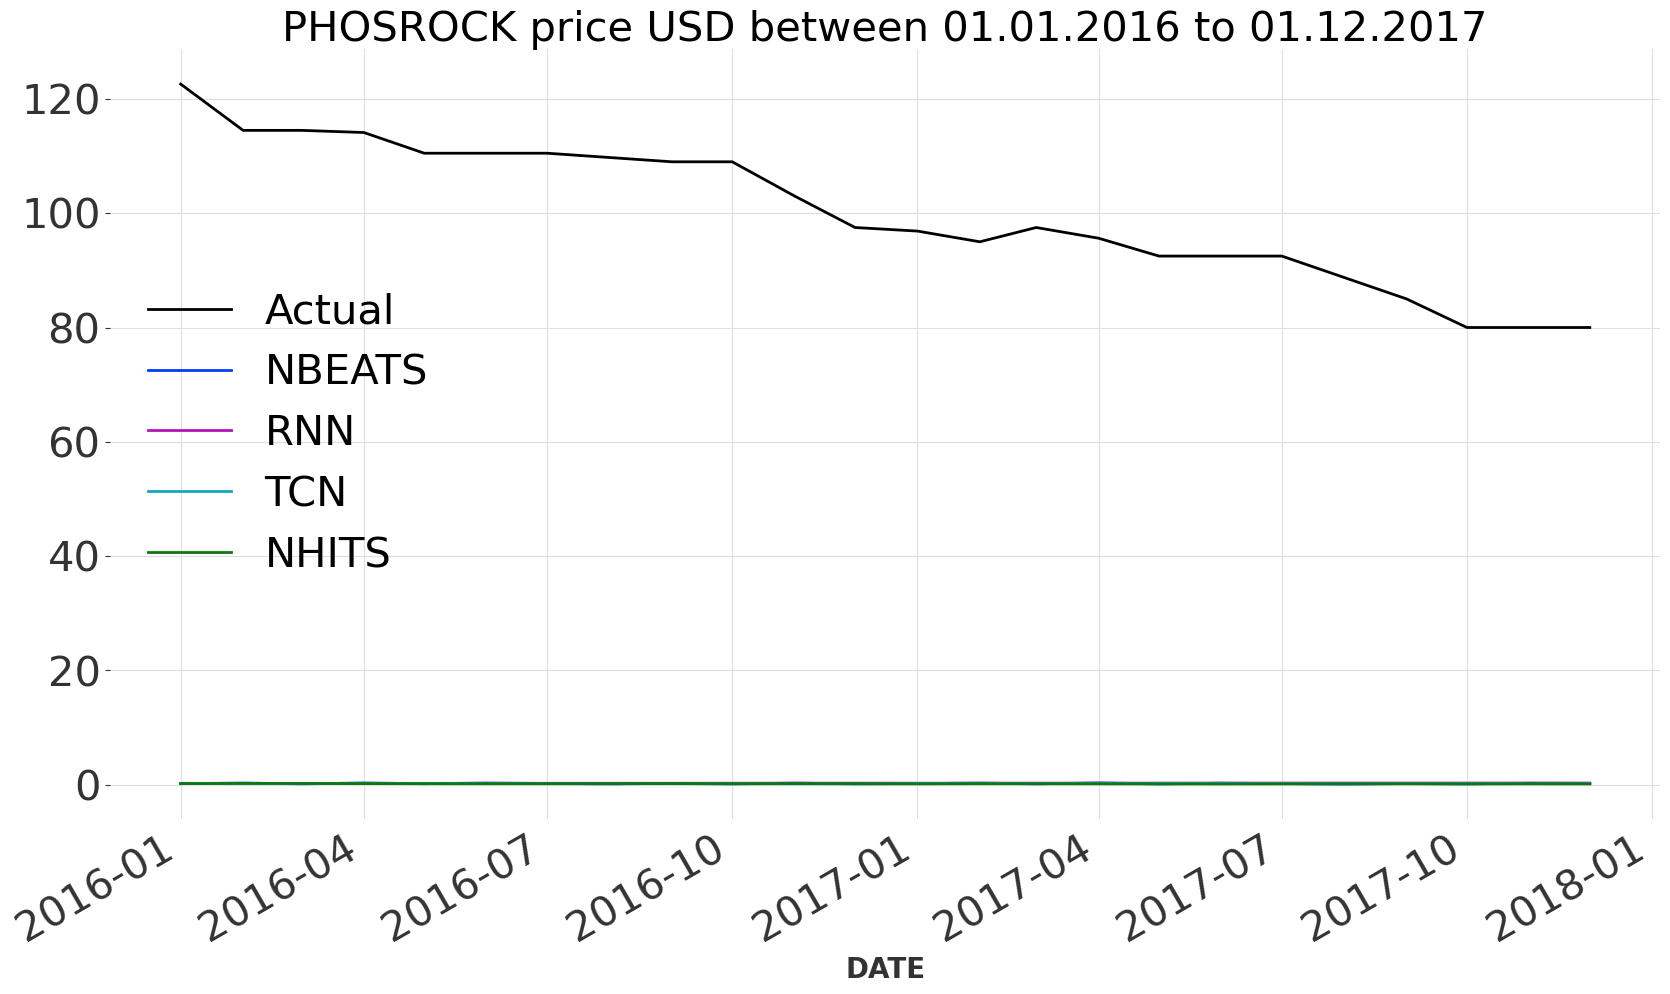

In [103]:
val[:24]['PHOSROCK'].plot(label='Actual')
pred_air['PHOSROCK'].plot(label='NBEATS')
pred_air_rnn['PHOSROCK'].plot(label='RNN')
pred_air_tcn['PHOSROCK'].plot(label='TCN')
pred_air_nhit['PHOSROCK'].plot(label='NHITS')
plt.title('PHOSROCK price USD between 01.01.2016 to 01.12.2017')

Text(0.5, 1.0, 'GOLD price USD between 01.01.2016 to 01.12.2017')

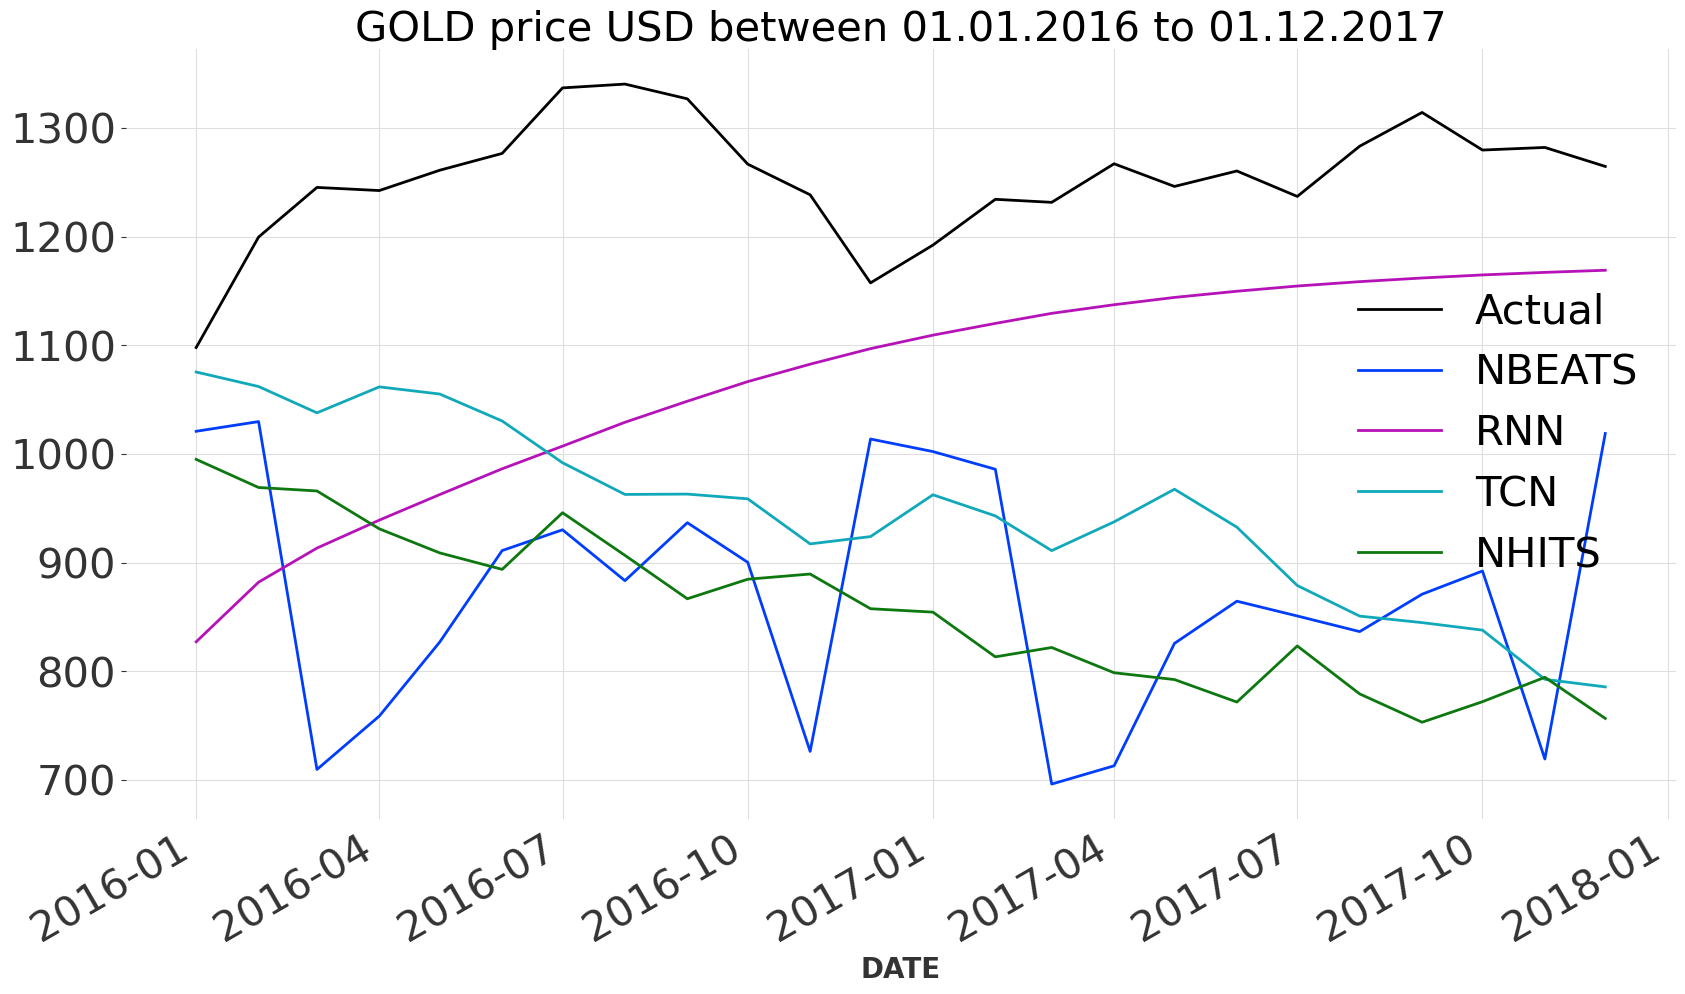

In [94]:
val[:24]['GOLD'].plot(label='Actual')
pred_air['GOLD'].plot(label='NBEATS')
pred_air_rnn['GOLD'].plot(label='RNN')
pred_air_tcn['GOLD'].plot(label='TCN')
pred_air_nhit['GOLD'].plot(label='NHITS')
plt.title('GOLD price USD between 01.01.2016 to 01.12.2017')

In [ ]:
val[:12]['POTASH'].plot(label='Actual')
pred_air['POTASH'].plot(label='NBEATS')
pred_air_rnn['POTASH'].plot(label='RNN')
pred_air_tcn['POTASH'].plot(label='TCN')
pred_air_nhit['POTASH'].plot(label='NHITS')


## forecasting fir future values 

In [135]:
train_all, val_all = data[:-5], data[-40:]

In [143]:
transformer_all_all = Scaler()
transformer_all_all.fit(data)
data_all = transformer_all_all.transform(data)

In [136]:
transformer_all = Scaler()
transformer_all.fit(train_all)
train_all = transformer_all.transform(train_all)
val_all   = transformer_all.transform(val_all)

In [137]:
# A TorchMetric or val_loss can be used as the monitor
torch_metrics_nhit_all = MeanAbsolutePercentageError()

# Early stop callback
my_stopper_nhit_all = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",  # "val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs_nhit_all = {"callbacks": [my_stopper_nhit_all]}

# Create the model
model_nhit_all = NHiTSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=500,
    torch_metrics=torch_metrics_nhit_all,
    pl_trainer_kwargs=pl_trainer_kwargs_nhit_all)

model_nhit_all.fit(
    series=train_all,
    val_series=val_all,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.4 M 
---------------------------------------------------
1.3 M     Trainable params
160 K     Non-trainable params
1.4 M     Total params
11.328    Total estimated model params size (MB)


Epoch 0:  96%|▉| 23/24 [00:01<00:00, 12.99it/s, loss=0.014
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 24/24 [00:02<00:00, 11.51it/s, loss=0.014
Epoch 1:  96%|▉| 23/24 [00:01<00:00, 12.77it/s, loss=0.006
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 24/24 [00:01<00:00, 12.71it/s, loss=0.006
Epoch 2:  96%|▉| 23/24 [00:02<00:00, 10.18it/s, loss=0.004
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 24/24 [00:02<00:00,  9.97it/s, loss=0.004
Epoch 3:  96%|▉| 23/24 [00:01<00:00, 14.44it/s, loss=0.003
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/1 [00:00<?, ?it/s]
Epoch 3: 100%|█| 24/24 [00:01<00:00, 14.65it/s, loss=0.003
Epoch 4:  96%|▉| 23/24 [00:01<00:00, 15.26it/s, loss=0.002
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/1 [00:00<?, ?it/s]
Epoch 4: 100%|█| 24

In [144]:
pred_nhit_data_all = model_nhit_all.predict(series=data_all, n=24)

Predicting DataLoader 0: 100%|█| 1/1 [00:00<00:00, 17.18it


In [151]:
pred_nhit_data_all = transformer_all_all.inverse_transform(pred_nhit_data_all )

In [152]:
pred_nhit_data_all.to_csv('multi_nhit_24.csv')

Number of components is larger than 10 (13). Plotting only the first 10 components.


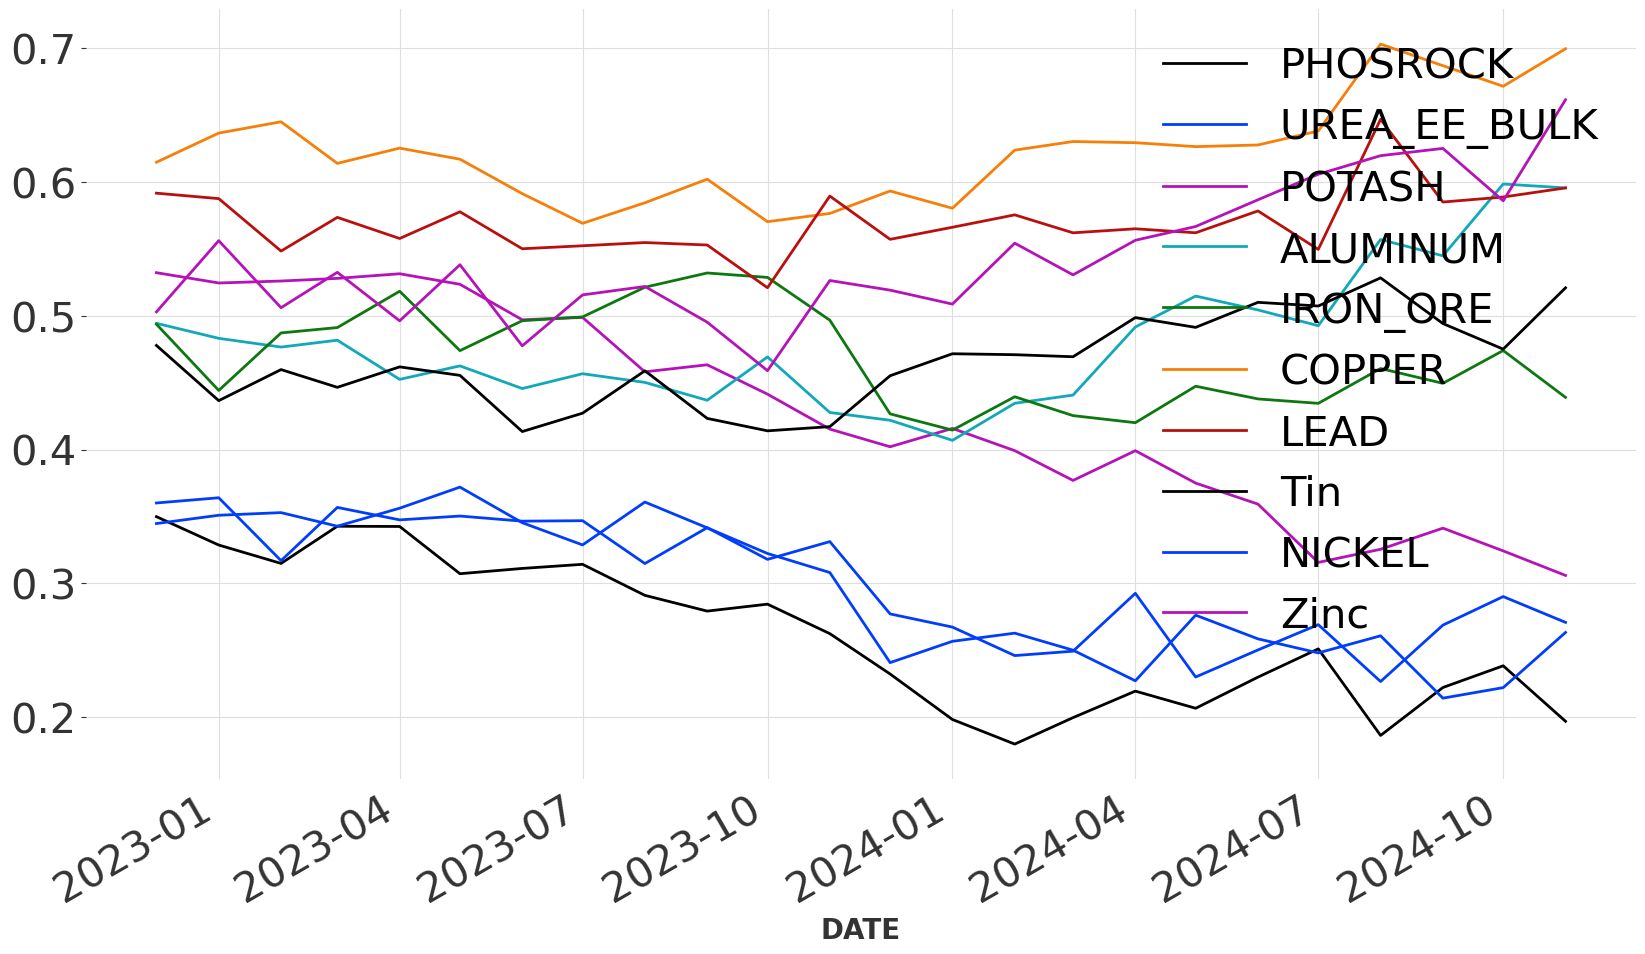

In [146]:
pred_nhit_data_all.plot()

In [147]:
# A TorchMetric or val_loss can be used as the monitor
torch_metrics_tcn_all = MeanAbsolutePercentageError()

# Early stop callback
my_stopper_tcn_all = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",  # "val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs_tcn_all = {"callbacks": [my_stopper_tcn_all]}

# Create the model
model_tcn_all = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=500,
    torch_metrics=torch_metrics_tcn_all,
    pl_trainer_kwargs=pl_trainer_kwargs_tcn_all)

model_tcn_all.fit(
    series=train_all,
    val_series=val_all,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 464   
----------------------------------------------------
464       Trainable params
0         Non-trainable params
464       Total params
0.004     Total estimated model params size (MB)


Epoch 0:  96%|▉| 23/24 [00:00<00:00, 23.56it/s, loss=0.255
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 24/24 [00:01<00:00, 23.56it/s, loss=0.255
Epoch 1:  96%|▉| 23/24 [00:01<00:00, 13.39it/s, loss=0.185
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 24/24 [00:01<00:00, 13.46it/s, loss=0.185
Epoch 2:  96%|▉| 23/24 [00:01<00:00, 22.81it/s, loss=0.133
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 24/24 [00:01<00:00, 22.45it/s, loss=0.133
Epoch 3:  96%|▉| 23/24 [00:00<00:00, 28.95it/s, loss=0.086
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/1 [00:00<?, ?it/s]
Epoch 3: 100%|█| 24/24 [00:00<00:00, 28.38it/s, loss=0.086
Epoch 4:  96%|▉| 23/24 [00:01<00:00, 18.83it/s, loss=0.059
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|      | 0/1 [00:00<?, ?it/s]
Epoch 4: 100%|█| 24

In [148]:
pred_tcn_data_all = model_tcn_all.predict(series=data_all, n=24)

Predicting DataLoader 0: 100%|█| 1/1 [00:00<00:00, 25.14it


In [153]:
pred_tcn_data_all = transformer_all_all.inverse_transform(pred_tcn_data_all)

In [154]:
pred_tcn_data_all.to_csv('multi_tcn_24.csv')

Number of components is larger than 10 (13). Plotting only the first 10 components.


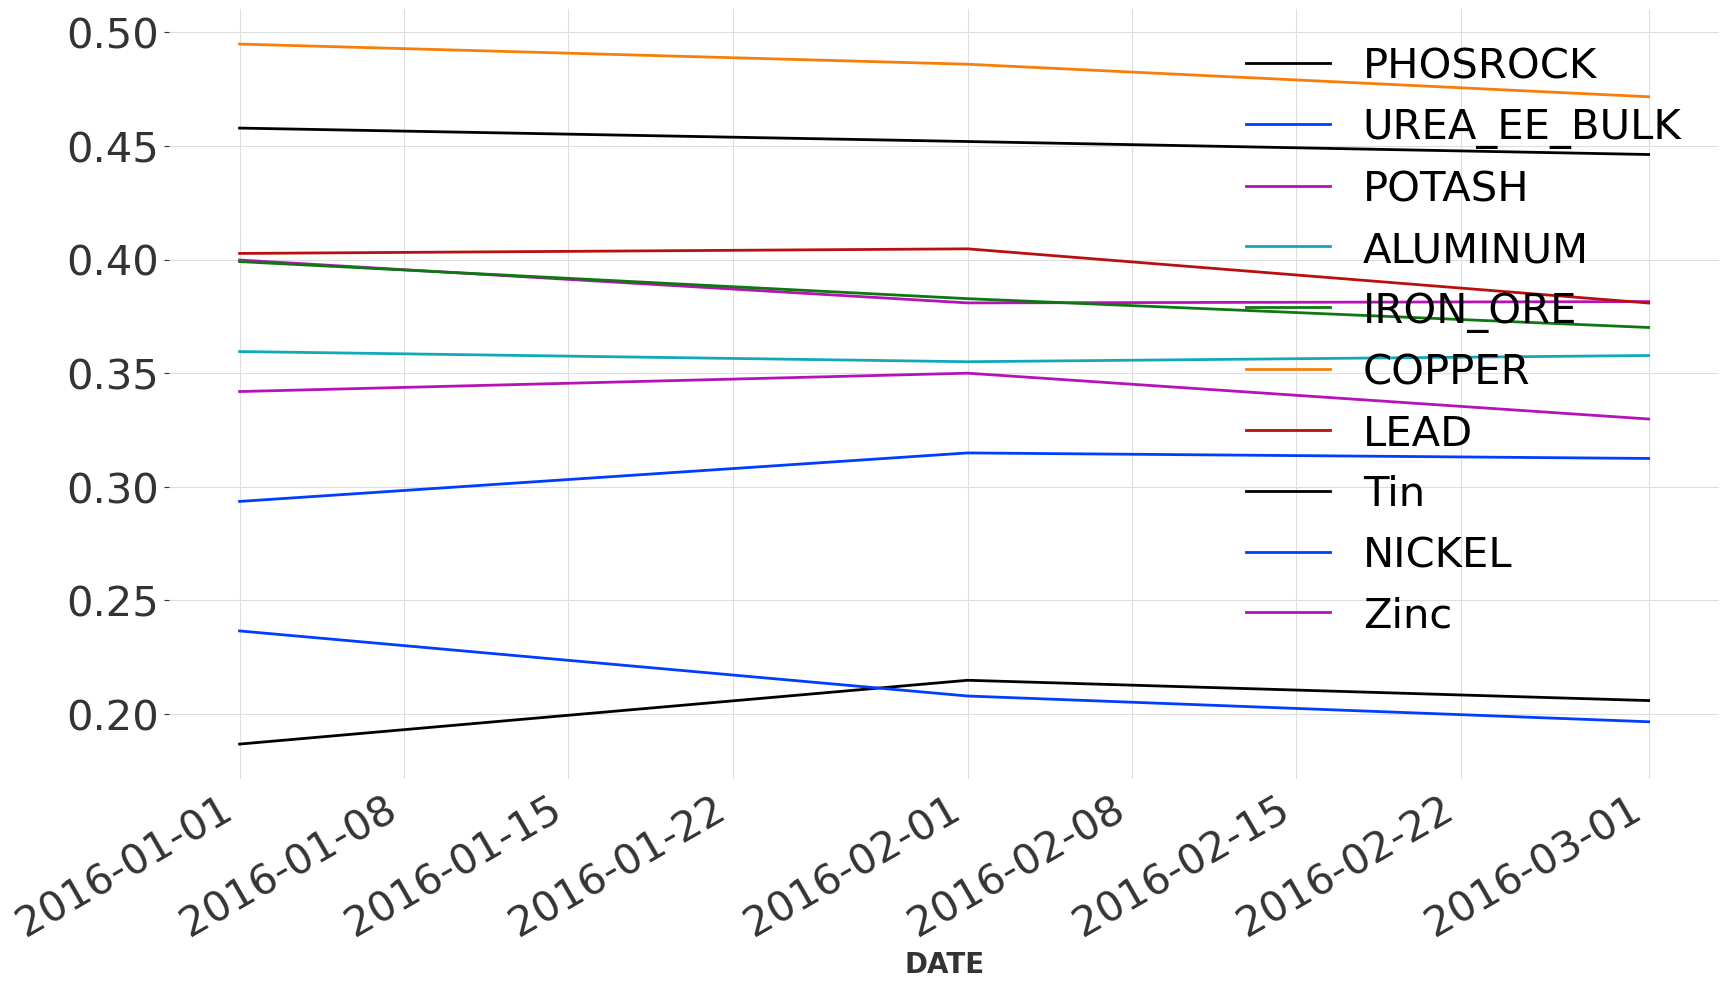

In [158]:
pred_air_nhit[:3].plot()